# PHISHING WEBSITE DETECTION

## Problem Statement:

### Develop an intelligent and adaptive system using Machine Learning to classify a given URL/website as either Legitimate (Benign) or Phishing (Malicious).

## Objective:

1. To extract meaningful URL-based and website-level features that help distinguish phishing websites from legitimate ones.

2. To train and evaluate multiple machine learning classification models such as Random Forest, SVM, and Logistic Regression using the engineered features.

3. To compare model performance using key metrics like Accuracy, Precision, Recall, F1-Score, ROC-AUC, and False Positive Rate (FPR).

4. To select and export the best-performing model as a production-ready pipeline suitable for real-time phishing detection.

## 1. Import Important Libraries:

In [1]:
# 1. Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import joblib


In [6]:
# Warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)

## 2. Loading of Dataset:

The features are extracted and store in the csv file. The working of this can be seen in the 'Phishing Website Detection_Feature Extraction.ipynb' file.

The reulted csv file is uploaded to this notebook and stored in the dataframe.

In [3]:
data0 = pd.read_csv("dataset_phishing.csv", on_bad_lines='skip', encoding='utf-8')
data0

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://www.fontspace.com/category/blackletter,45,17,0,2,0,0,0,0,0,...,0,0,0,448,5396,3980,0,0,6,legitimate
11426,http://www.budgetbots.com/server.php/Server%20...,84,18,0,5,0,1,1,0,0,...,1,0,0,211,6728,0,0,1,0,phishing
11427,https://www.facebook.com/Interactive-Televisio...,105,16,1,2,6,0,1,0,0,...,0,0,0,2809,8515,8,0,1,10,legitimate
11428,http://www.mypublicdomainpictures.com/,38,30,0,2,0,0,0,0,0,...,1,0,0,85,2836,2455493,0,0,4,legitimate


In [4]:
data0.rename(columns={'status': 'label'}, inplace=True) # Renamed dataset label name 

In [7]:
data0['label'] = data0['label'].replace({
    'legitimate': 0,
    'phishing': 1
})

In [8]:
print(data0.head())

                                                 url  length_url  \
0              http://www.crestonwood.com/router.php          37   
1  http://shadetreetechnology.com/V4/validation/a...          77   
2  https://support-appleld.com.secureupdate.duila...         126   
3                                 http://rgipt.ac.in          18   
4  http://www.iracing.com/tracks/gateway-motorspo...          55   

   length_hostname  ip  nb_dots  nb_hyphens  nb_at  nb_qm  nb_and  nb_or  ...  \
0               19   0        3           0      0      0       0      0  ...   
1               23   1        1           0      0      0       0      0  ...   
2               50   1        4           1      0      1       2      0  ...   
3               11   0        2           0      0      0       0      0  ...   
4               15   0        2           2      0      0       0      0  ...   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0                0                

## 2. Familiarizing with Data (Data and Features):

## Target Variable

**`label`**

- **Type:** Integer (0 or 1)  
- **Meaning:**  
  - `0` → Legitimate website  
  - `1` → Phishing website  
- **Distribution (approx):**  
  -  **50.0%** → Phishing  
  -  **50.0%** → Legitimate


## Summary of Dataset Features

| Feature Name                  | Type        | Category        | Description                                                                 |
|-------------------------------|-------------|------------------|-----------------------------------------------------------------------------|
| url                           | String      | Lexical         | Full website URL                                                            |
| length_url                    | Integer     | Lexical         | Total length of the URL                                                     |
| length_hostname               | Integer     | Lexical         | Length of the hostname/domain                                               |
| ip                            | Integer     | Lexical         | Indicates if IP address is used instead of domain (1 = Yes, 0 = No)        |
| nb_dots                       | Integer     | Lexical         | Number of dot characters (`.`) in the URL                                   |
| nb_hyphens                    | Integer     | Lexical         | Number of hyphens (`-`) in the URL                                          |
| nb_at                         | Integer     | Lexical         | Number of `@` symbols                                                       |
| nb_qm                         | Integer     | Lexical         | Number of question marks (`?`)                                              |
| nb_and                        | Integer     | Lexical         | Number of ampersands (`&`)                                                  |
| nb_or                         | Integer     | Lexical         | Number of OR (`|`) characters                                               |
| nb_eq                         | Integer     | Lexical         | Number of equal signs (`=`)                                                 |
| nb_underscore                 | Integer     | Lexical         | Number of underscores (`_`)                                                 |
| nb_tilde                      | Integer     | Lexical         | Number of tildes (`~`)                                                      |
| nb_percent                    | Integer     | Lexical         | Number of percentage (`%`) characters                                       |
| nb_slash                      | Integer     | Lexical         | Number of forward slashes (`/`) after the domain                            |
| nb_star                       | Integer     | Lexical         | Number of asterisk (`*`) symbols                                            |
| nb_semicolon                  | Integer     | Lexical         | Number of semicolons (`;`)                                                  |
| nb_www                        | Integer     | Lexical         | Count of "www" occurrences                                                  |
| nb_com                        | Integer     | Lexical         | Count of ".com" occurrences                                                 |
| nb_dollar                     | Integer     | Lexical         | Number of `$` symbols                                                       |
| disease_tld                   | Integer     | Lexical         | Checks if suspicious or rare TLD is used                                    |
| prefix_suffix                 | Integer     | Lexical         | Presence of hyphen in domain (common phishing indicator)                    |
| random_domain                 | Integer     | Lexical         | Indicates if domain string appears random/unusual                            |
| shortening_service            | Integer     | Lexical         | Detects URL shortening services (bit.ly, tinyurl)                           |
| tld                           | Categorical | Host-based      | Top-Level Domain (e.g., .com, .org)                                         |
| whois_registered_domain       | Integer     | Host-based      | Shows if WHOIS record exists                                                |
| domain_registration_length    | Integer     | Host-based      | Duration until domain expiry                                                |
| domain_age                    | Integer     | Host-based      | Age of domain (in days/months)                                              |
| dns_record                    | Integer     | Host-based      | Presence or absence of DNS records                                          |
| web_traffic                   | Integer     | Traffic         | Web traffic ranking score (similar to Alexa Rank)                           |
| google_index                  | Integer     | Traffic         | Indicates whether URL is indexed by Google                                  |
| page_rank                     | Integer     | Traffic         | PageRank score indicating domain authority                                  |
| iframe                        | Integer     | Content         | Detects iframe usage in webpage content                                     |
| popup_window                  | Integer     | Content         | Presence of popup windows                                                   |
| safe_anchor                   | Integer     | Content         | Checks if anchor tags point to unsafe or external links                     |
| onmouseover                   | Integer     | Content         | Detects mouseover script manipulation                                       |
| right_clic                    | Integer     | Content         | Checks if right-click is disabled                                           |
| empty_title                   | Integer     | Content         | Indicates if the page title is empty                                        |
| domain_in_title               | Integer     | Content         | Whether the domain appears in the title (legitimacy indicator)              |
| domain_with_copyright         | Integer     | Content         | Fake or misleading copyright statements                                     |
| **label**                    | **Integer** | **Target**       | **1 = Phishing, 0 = Legitimate**                                            |


## 3. Data Cleaning:

In [10]:
data0.shape

(11430, 89)

In [11]:
data0.columns

Index(['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens',
       'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore',
       'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma',
       'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com',
       'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url',
       'ratio_digits_host', 'punycode', 'port', 'tld_in_path',
       'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains',
       'prefix_suffix', 'random_domain', 'shortening_service',
       'path_extension', 'nb_redirection', 'nb_external_redirection',
       'length_words_raw', 'char_repeat', 'shortest_words_raw',
       'shortest_word_host', 'shortest_word_path', 'longest_words_raw',
       'longest_word_host', 'longest_word_path', 'avg_words_raw',
       'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand',
       'brand_in_subdomain', 'brand_in_path', 'suspecious_tld',
       'statistical_report', 

In [12]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

### Dataset Overview

| Property | Value |
|--------|-------|
| Total Records | **11,430** |
| Total Features | **89** |
| Dataset Type | Binary Classification (Phishing Detection) |
| Target Variable | **`label`** |
| Target Values || 0 → Legitimate URL || 1 → Phishing URL |

---

###  Target Variable Description

#### `label`
| Value | Meaning |
|------|--------|
| `0` | Legitimate |
| `1` | Phishing |

- Mean value ≈ **0.50** → Having same no of phishing URLs and legitimate URLs.

---


In [34]:
data0.describe()

,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,nb_eq,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,label
count,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,11430.0,11430.000000,...,11430.000000,11430.000000,11430.000000,11430.000000,11430.000000,1.143000e+04,11430.000000,11430.000000,11430.000000,11430.000000
mean,61.126684,21.090289,0.150569,2.480752,0.997550,0.022222,0.141207,0.162292,0.0,0.293176,...,0.775853,0.439545,0.072878,492.532196,4062.543745,8.567566e+05,0.020122,0.533946,3.185739,0.500000
std,55.297318,10.777171,0.357644,1.369686,2.087087,0.155500,0.364456,0.821337,0.0,0.998317,...,0.417038,0.496353,0.259948,814.769415,3107.784600,1.995606e+06,0.140425,0.498868,2.536955,0.500022
min,12.000000,4.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,-1.000000,-12.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,33.000000,15.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,84.000000,972.250000,0.000000e+00,0.000000,0.000000,1.000000,0.000000
50%,47.000000,19.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,0.000000,0.000000,242.000000,3993.000000,1.651000e+03,0.000000,1.000000,3.000000,0.500000
75%,71.000000,24.000000,0.000000,3.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,1.000000,1.000000,0.000000,449.000000,7026.750000,3.738455e+05,0.000000,1.000000,5.000000,1.000000
max,1641.000000,214.000000,1.000000,24.000000,43.000000,4.000000,3.000000,19.000000,0.0,19.000000,...,1.000000,1.000000,1.000000,29829.000000,12874.000000,1.076799e+07,1.000000,1.000000,10.000000,1.000000


In [13]:

data = data0.drop(['Domain'], axis=1, errors='ignore').copy()

# Drop rows with any missing values
data = data.dropna()

# Drop duplicate rows (optional but safe)
data = data.drop_duplicates()

data = data.sample(frac=1, random_state=42).reset_index(drop=True)

print("Shuffled and cleaned data shape:", data.shape)

Shuffled and cleaned data shape: (11430, 89)


### Visualizing the data

A correlation heatmap is a visual representation of the correlation matrix, showing how strongly different features are related to each other using color intensity.


It helps quickly identify patterns, feature relationships, and multicollinearity, allowing us to understand which features may be redundant or important for model building.

Constant columns removed from heatmap: ['nb_or', 'ratio_nullHyperlinks', 'ratio_intRedirection', 'ratio_intErrors', 'submit_email', 'sfh']


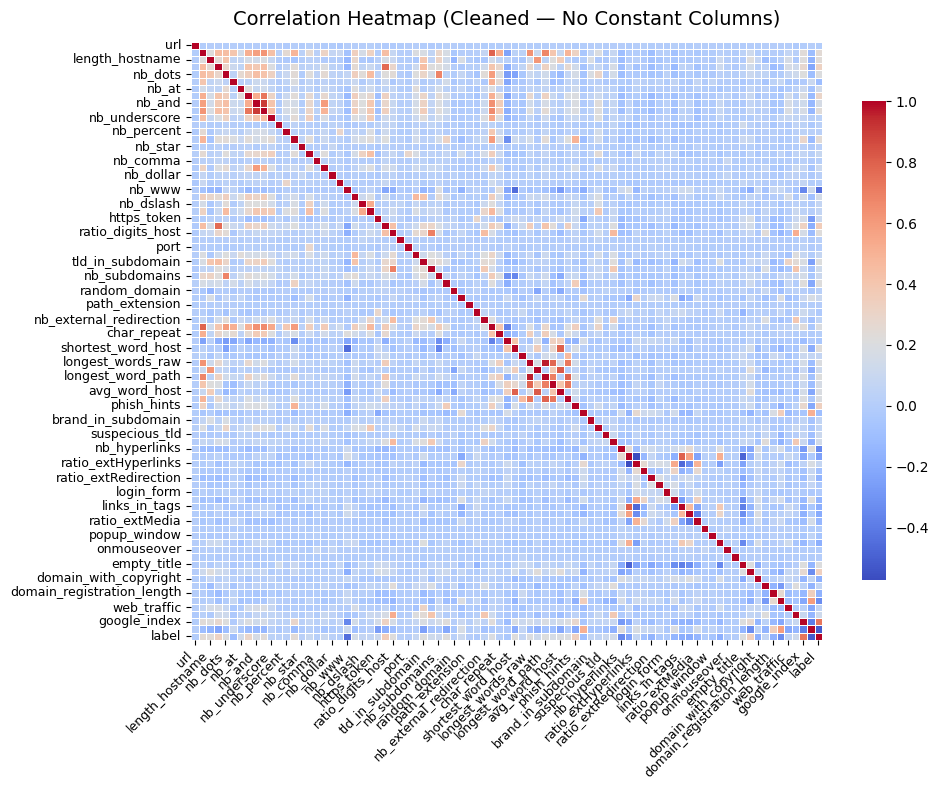

In [14]:
# Ensure encoded_data exists; if not, try to build a numeric-encoded version from available variables
if 'encoded_data' not in globals():
    if 'data' in globals():
        encoded_data = data.copy()
    elif 'data0' in globals():
        encoded_data = data0.copy()
    else:
        raise NameError("encoded_data is not defined and neither 'data' nor 'data0' are available. Run the preprocessing cells first.")

# Encode non-numeric (object/category) columns to numeric codes so correlation can be computed
obj_cols = encoded_data.select_dtypes(include=['object', 'category']).columns.tolist()
for col in obj_cols:
    encoded_data[col] = pd.factorize(encoded_data[col])[0]

# 🔹 1) Remove constant / zero-variance columns (these cause NaN correlations)
constant_cols = encoded_data.columns[encoded_data.nunique() <= 1]
# Optional: see which ones got removed
print("Constant columns removed from heatmap:", list(constant_cols))

encoded_data_clean = encoded_data.drop(columns=constant_cols)

# 🔹 2) Compute correlation matrix
corr = encoded_data_clean.corr()

# 🔹 3) Drop rows/cols that are all NaN (just in case)
corr = corr.dropna(axis=0, how='all').dropna(axis=1, how='all')

# 🔹 4) Fill any remaining NaNs with 0 (neutral correlation)
corr = corr.fillna(0)

# 🔹 5) Plot heatmap without white lines
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    cmap='coolwarm',
    annot=False,
    cbar_kws={'shrink': 0.8},
    linewidths=0.5
)

plt.title('Correlation Heatmap (Cleaned — No Constant Columns)', fontsize=14, pad=12)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


#### Observation

The diagonal is deep red because each feature correlates perfectly with itself.

Colors range from –1 (blue, negative) to +1 (red, positive), with light colors showing weak correlations.

The matrix is symmetric.

Most areas are light, meaning features are mostly independent.

White lines show features with very low variance or sparse categorical value.
#### Insights
**Positive Correlations**

Character-count features (dots, hyphens, @, slashes) rise together → complex URLs contain multiple special characters.

Path/query features show mild clustering → long URLs usually have more query symbols.

HTML/JS phishing signals (iframe, popup, onmouseover) align weakly → phishing pages often use multiple tricks.

**Negative Correlations**

Legitimate indicators (google_index, domain_in_title) oppose phishing behaviors (iframe, popup, onmouseover).

Older domains correlate negatively with strange URL patterns → newer phishing domains use unusual structures.

### Handle Missing Values:

Handling missing values involves identifying and replacing or removing incomplete data to ensure the dataset remains accurate and usable. We apply techniques like mean/median imputation, mode imputation, or dropping rows/columns so the machine learning model can train effectively without bias or errors.

In [15]:
# Check again for missing values
print("Missing values before cleaning:")
print(data0.isnull().sum())

# Fill numeric columns with median
num_cols = data0.select_dtypes(include=np.number).columns
for col in num_cols:
    data0[col].fillna(data0[col].median(), inplace=True)

# Fill categorical columns with mode
cat_cols = data0.select_dtypes(exclude=np.number).columns
for col in cat_cols:
    data0[col].fillna(data0[col].mode()[0], inplace=True)

print("\nMissing values after cleaning:")
print(data0.isnull().sum())


Missing values before cleaning:
url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
label              0
Length: 89, dtype: int64

Missing values after cleaning:
url                0
length_url         0
length_hostname    0
ip                 0
nb_dots            0
                  ..
web_traffic        0
dns_record         0
google_index       0
page_rank          0
label              0
Length: 89, dtype: int64


### Checking and removal of duplicate rows:

In [16]:
# 🔹 Check for duplicate rows
duplicate_rows = data.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_rows}")

# 🔹 Remove duplicate rows
data.drop_duplicates(inplace=True)

# 🔹 Verify removal
print(f"Shape after removing duplicate rows: {data.shape}")


Number of duplicate rows: 0
Shape after removing duplicate rows: (11430, 89)


### Checking and removal of duplicate columns:

In [51]:
# 🔹 Check for duplicate columns
duplicate_cols = data.columns[data.columns.duplicated()].tolist()
print(f"Duplicate columns found: {duplicate_cols}")

# 🔹 Remove duplicate columns (if any)
data = data.loc[:, ~data.columns.duplicated()]

# 🔹 Verify removal
print(f"Shape after removing duplicate columns: {data.shape}")


Duplicate columns found: []
Shape after removing duplicate columns: (11430, 89)


## Outlier Check:

Outlier Check:

Outlier checking helps identify values that lie far outside the normal range of the dataset and may influence model performance. These extreme points can distort statistical calculations, reduce model stability, or cause biased predictions.

Why We Have Not Removed Outliers:

We did not remove outliers because, in phishing detection, these extreme patterns often represent actual phishing behavior (e.g., unusual URL lengths, excessive special characters, suspicious scripts). Since these “outliers” are meaningful indicators of phishing attacks, removing them would cause a loss of important predictive information and reduce the model’s ability to detect real threats.

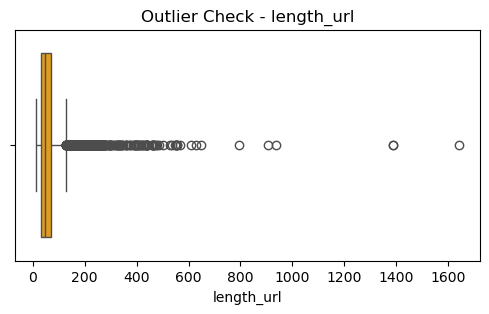

length_url → Outliers: 273


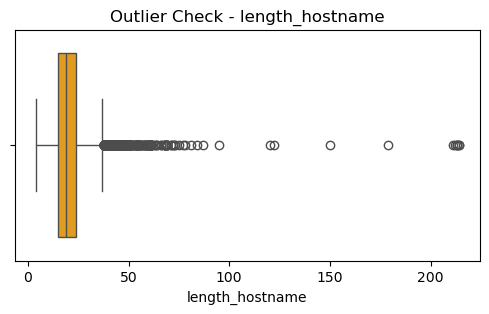

length_hostname → Outliers: 118


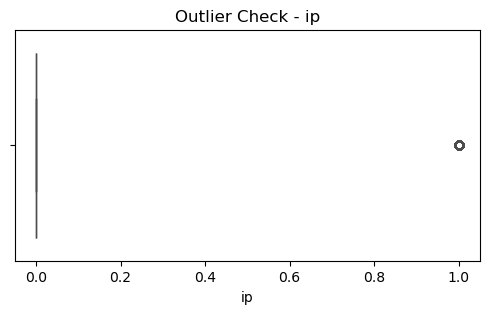

ip → Outliers: 1721


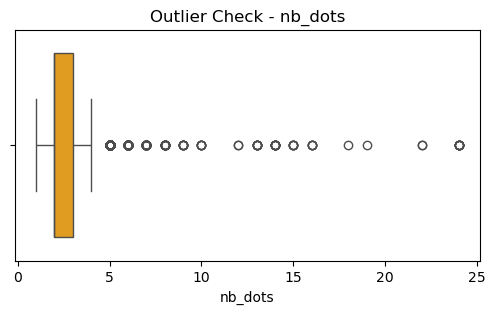

nb_dots → Outliers: 122


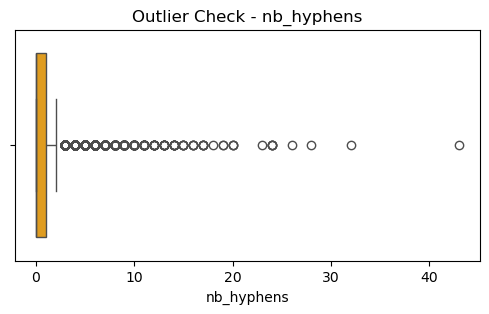

nb_hyphens → Outliers: 650


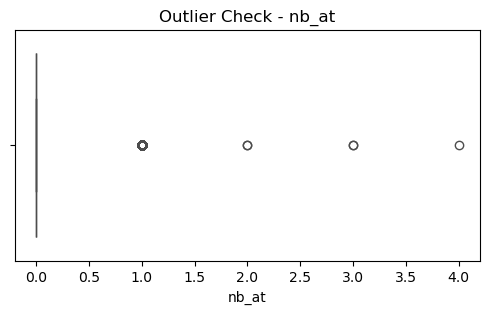

nb_at → Outliers: 245


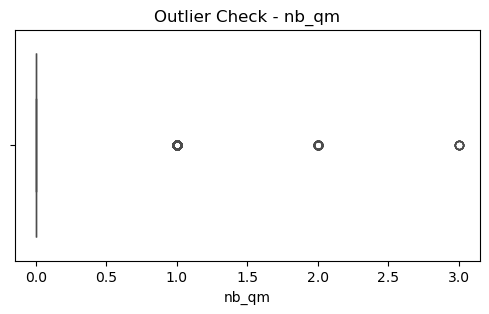

nb_qm → Outliers: 1555


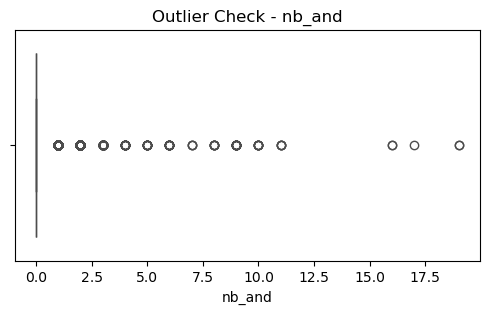

nb_and → Outliers: 761


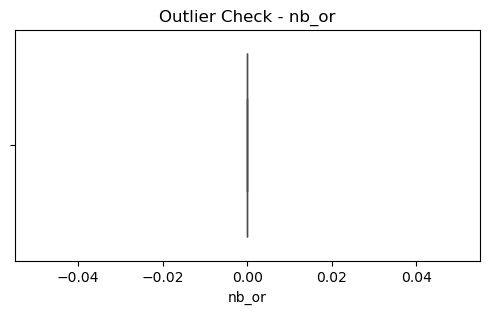

nb_or → Outliers: 0


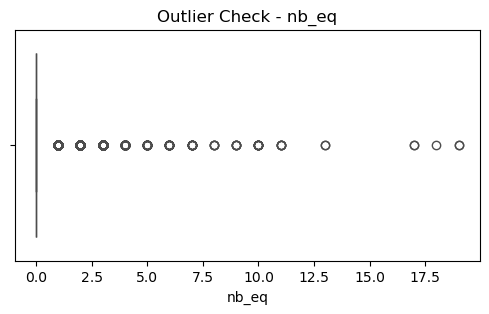

nb_eq → Outliers: 1564


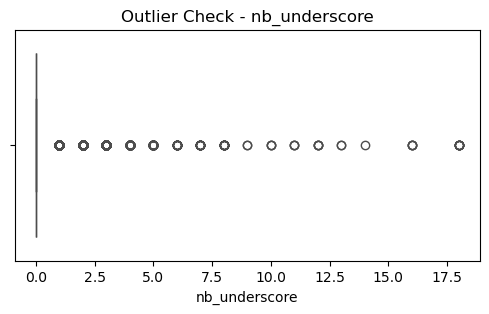

nb_underscore → Outliers: 1695


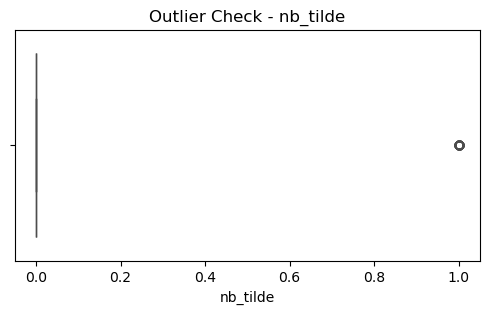

nb_tilde → Outliers: 76


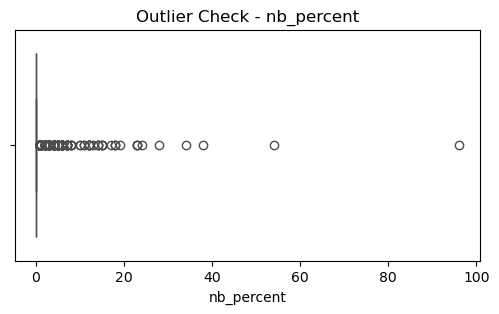

nb_percent → Outliers: 355


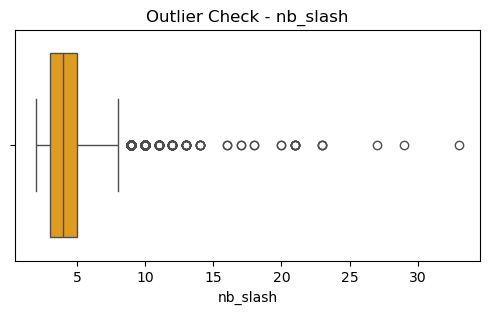

nb_slash → Outliers: 62


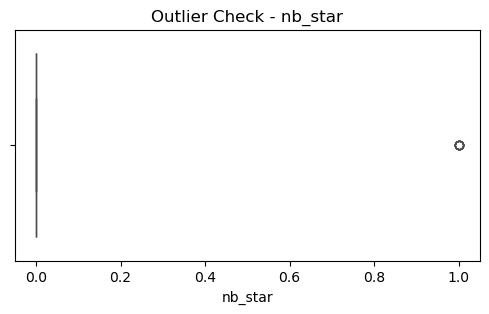

nb_star → Outliers: 8


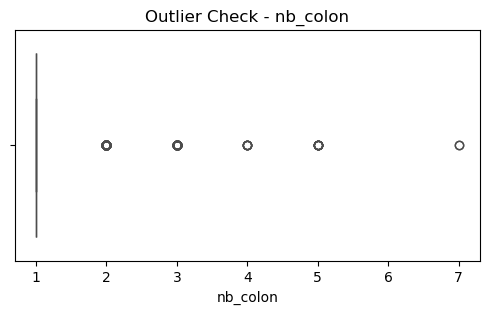

nb_colon → Outliers: 197


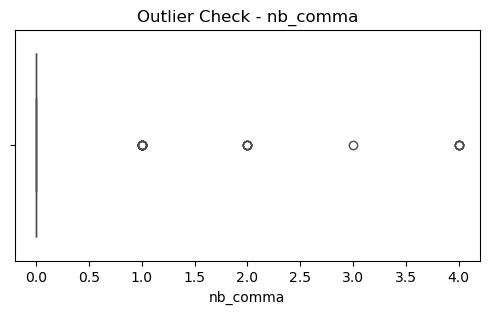

nb_comma → Outliers: 24


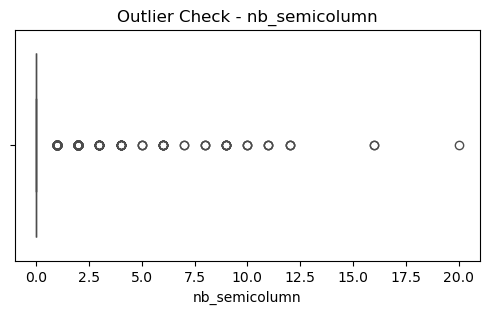

nb_semicolumn → Outliers: 248


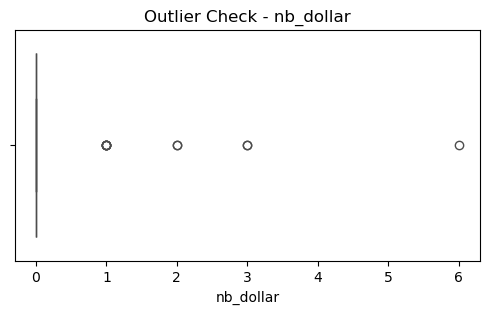

nb_dollar → Outliers: 11


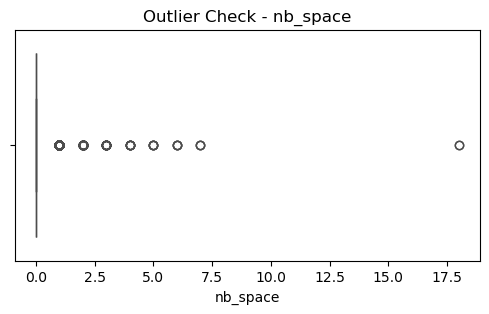

nb_space → Outliers: 210


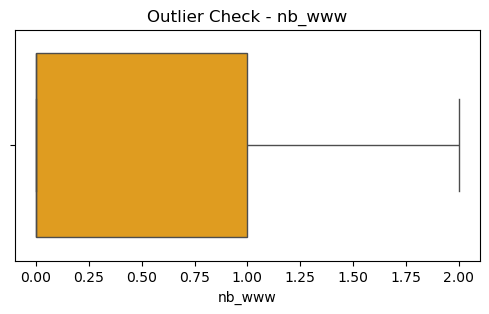

nb_www → Outliers: 0


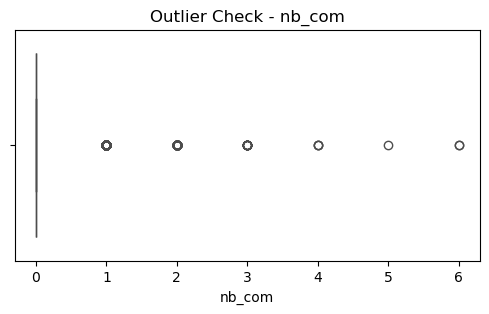

nb_com → Outliers: 1327


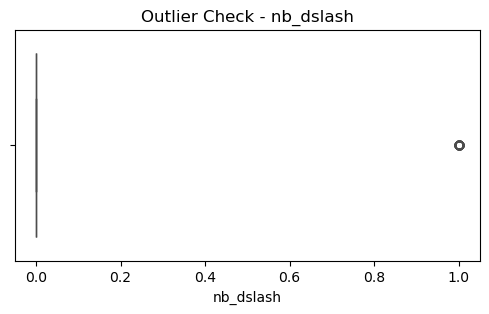

nb_dslash → Outliers: 75


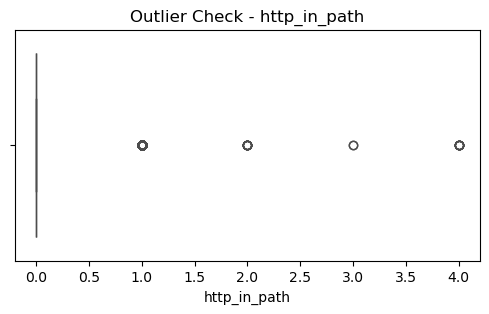

http_in_path → Outliers: 150


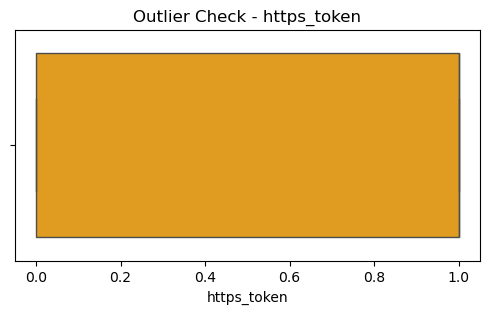

https_token → Outliers: 0


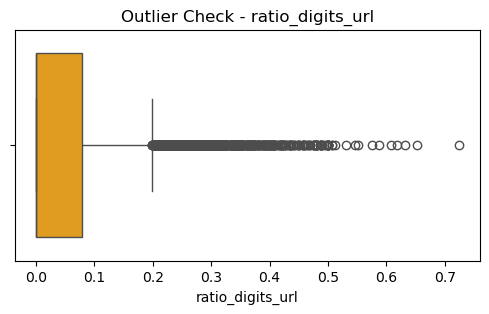

ratio_digits_url → Outliers: 266


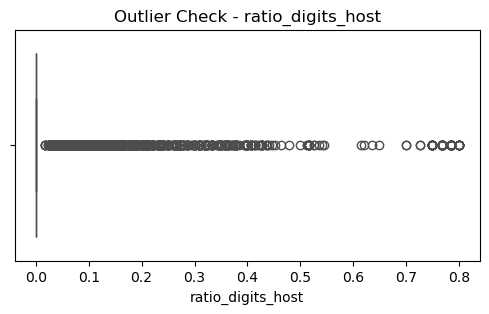

ratio_digits_host → Outliers: 1503


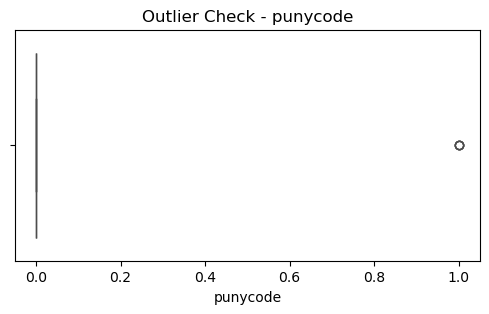

punycode → Outliers: 4


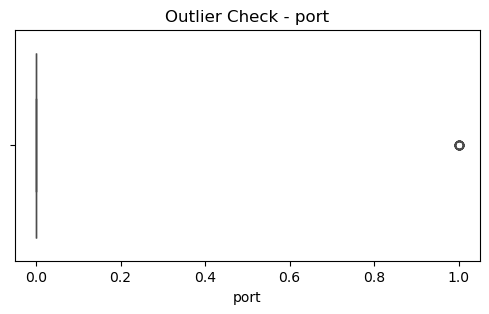

port → Outliers: 27


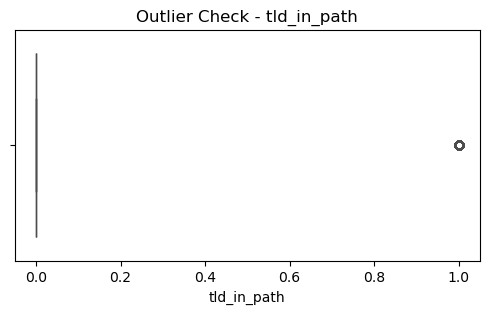

tld_in_path → Outliers: 750


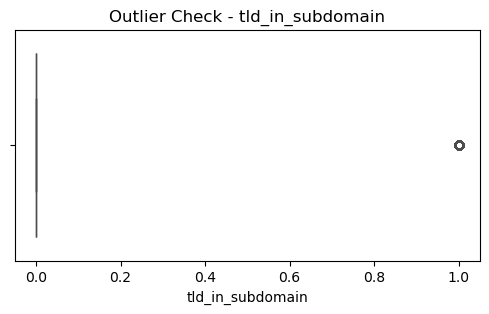

tld_in_subdomain → Outliers: 573


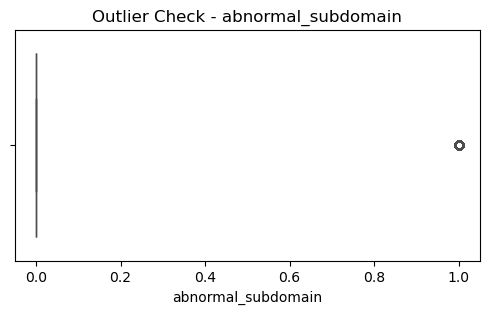

abnormal_subdomain → Outliers: 247


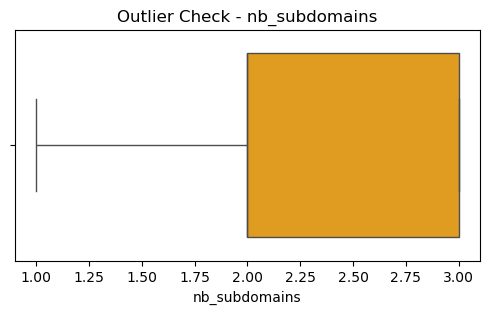

nb_subdomains → Outliers: 0


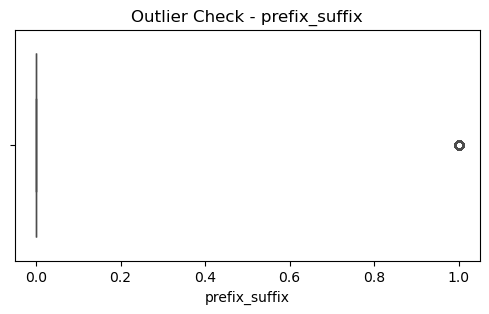

prefix_suffix → Outliers: 2314


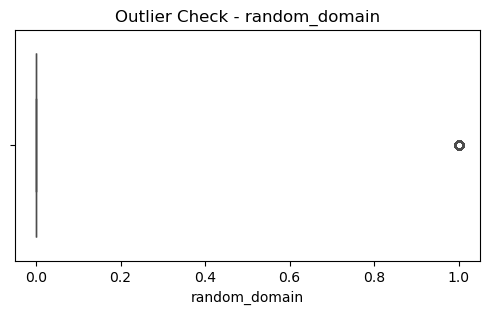

random_domain → Outliers: 952


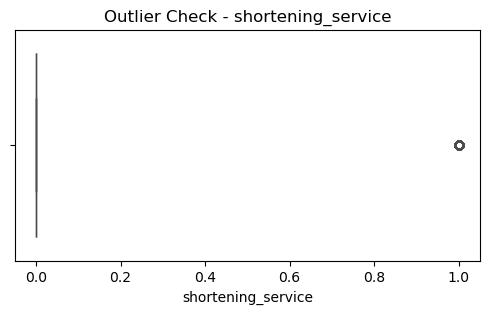

shortening_service → Outliers: 1411


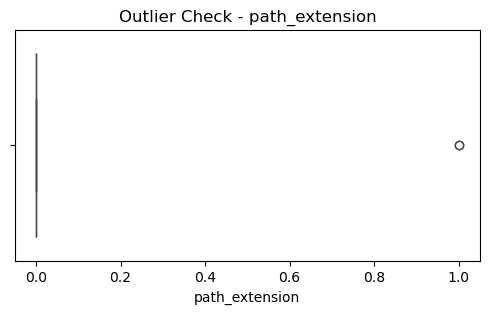

path_extension → Outliers: 2


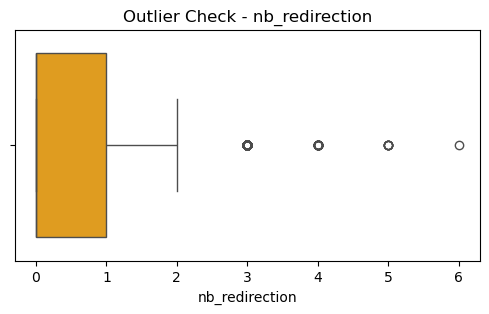

nb_redirection → Outliers: 7


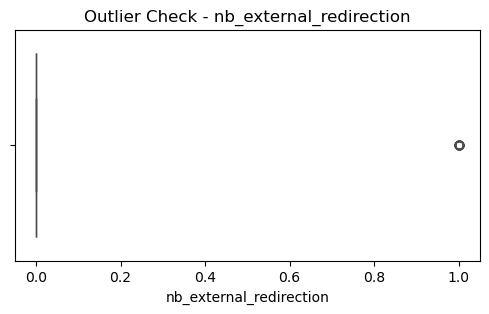

nb_external_redirection → Outliers: 36


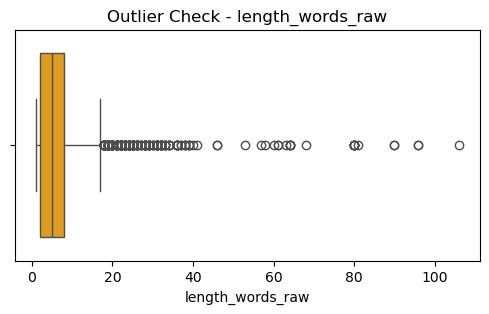

length_words_raw → Outliers: 86


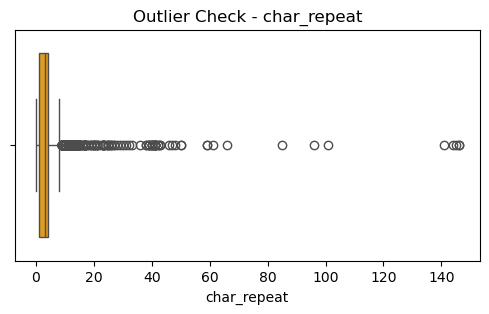

char_repeat → Outliers: 137


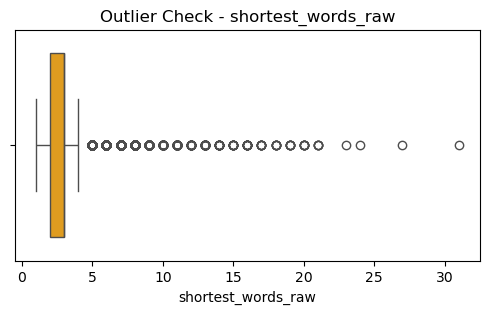

shortest_words_raw → Outliers: 906


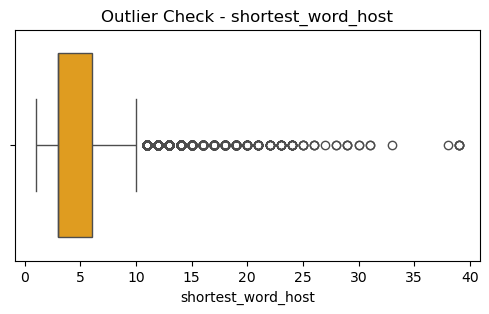

shortest_word_host → Outliers: 336


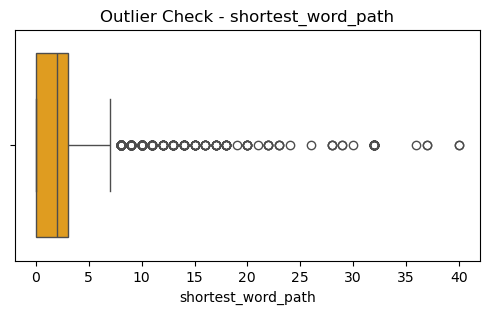

shortest_word_path → Outliers: 134


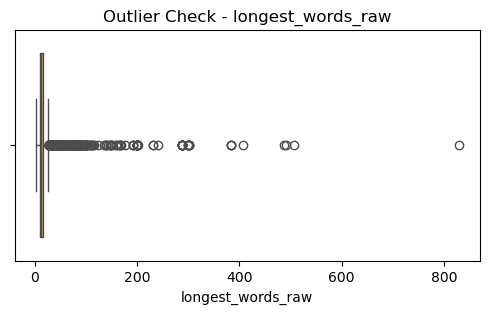

longest_words_raw → Outliers: 432


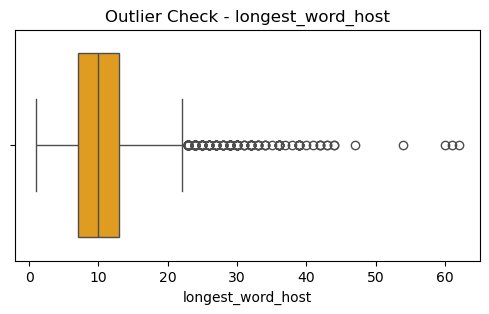

longest_word_host → Outliers: 52


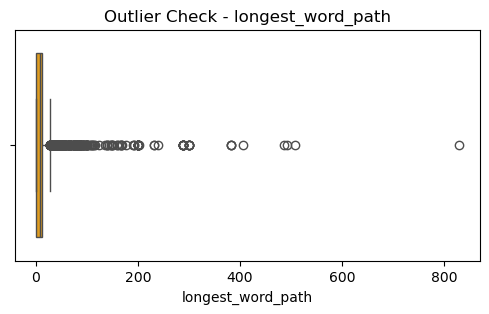

longest_word_path → Outliers: 292


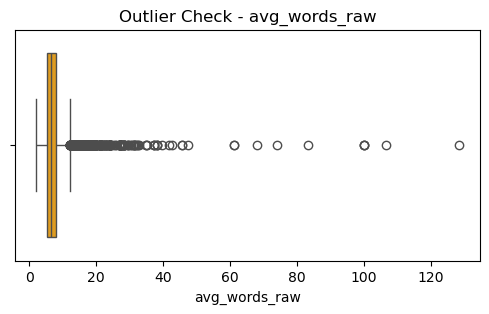

avg_words_raw → Outliers: 220


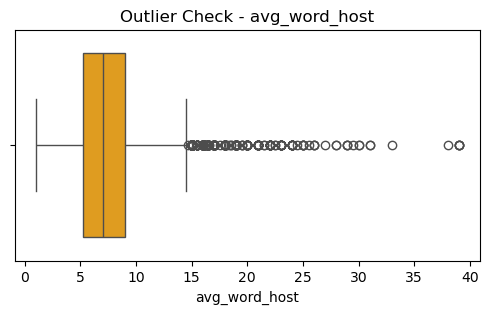

avg_word_host → Outliers: 91


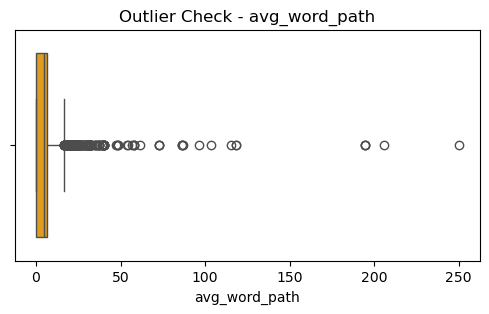

avg_word_path → Outliers: 114


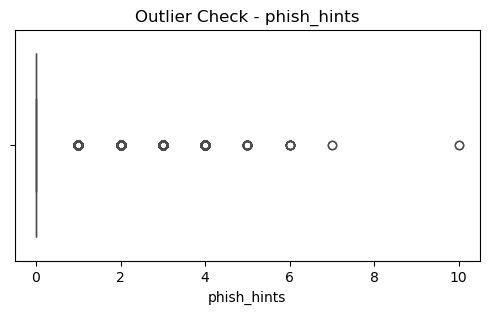

phish_hints → Outliers: 2041


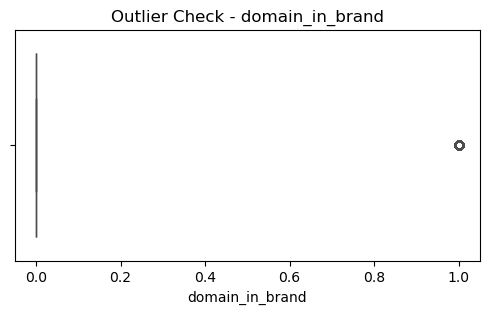

domain_in_brand → Outliers: 1191


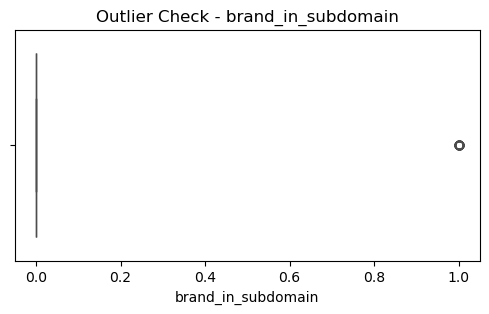

brand_in_subdomain → Outliers: 47


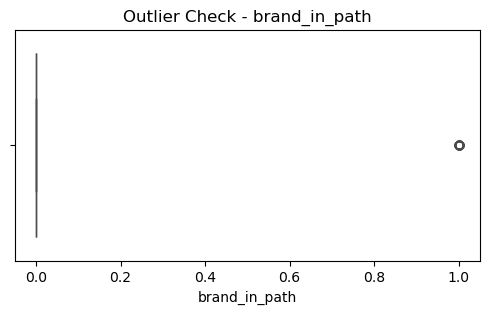

brand_in_path → Outliers: 56


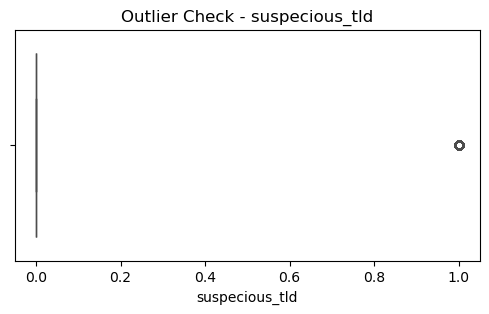

suspecious_tld → Outliers: 205


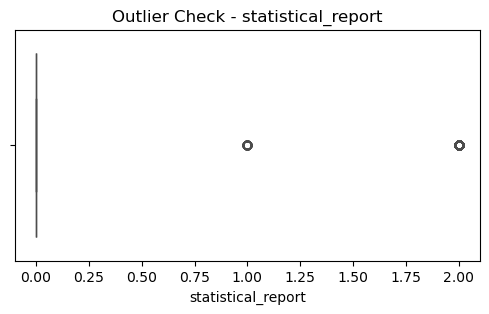

statistical_report → Outliers: 377


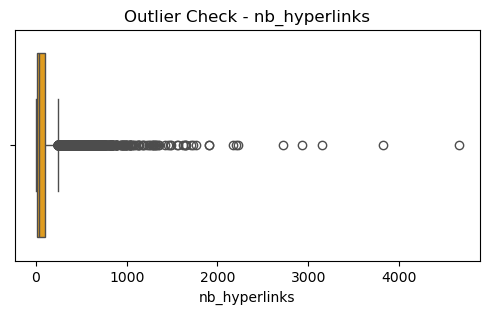

nb_hyperlinks → Outliers: 455


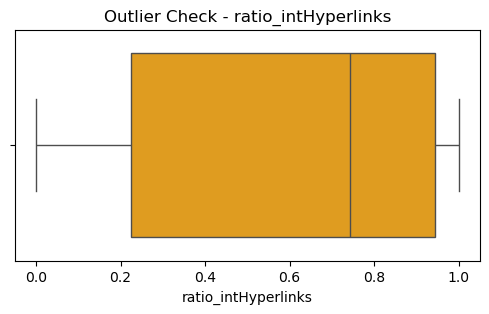

ratio_intHyperlinks → Outliers: 0


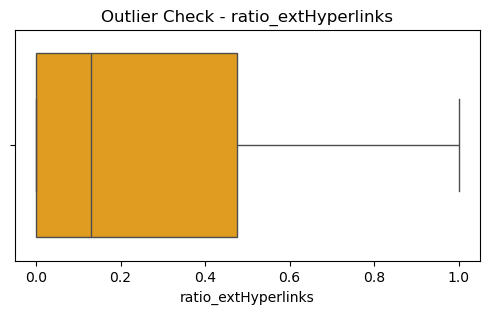

ratio_extHyperlinks → Outliers: 0


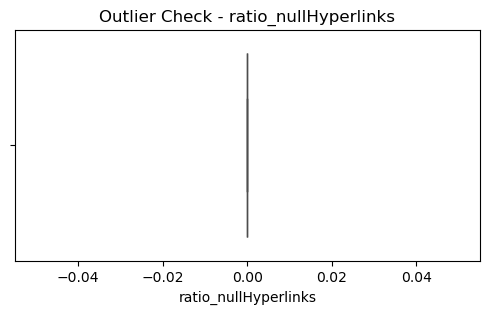

ratio_nullHyperlinks → Outliers: 0


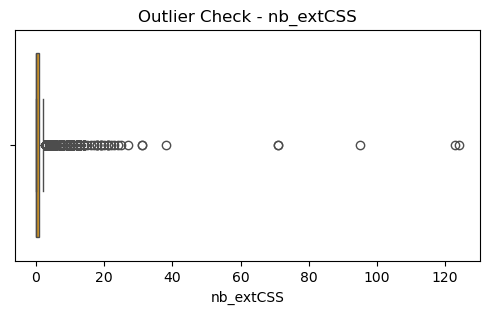

nb_extCSS → Outliers: 389


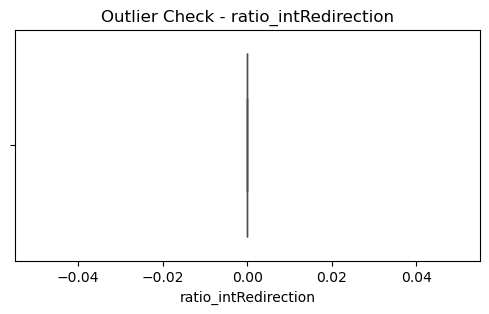

ratio_intRedirection → Outliers: 0


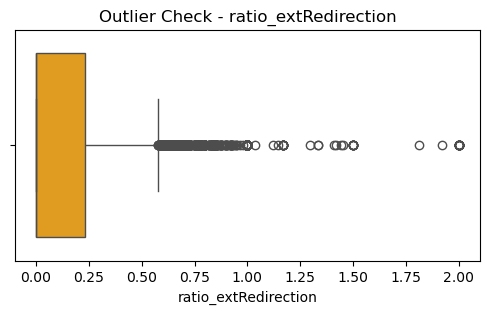

ratio_extRedirection → Outliers: 349


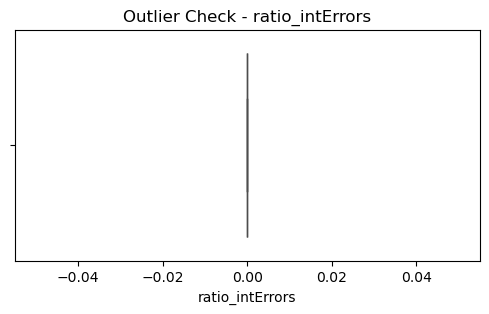

ratio_intErrors → Outliers: 0


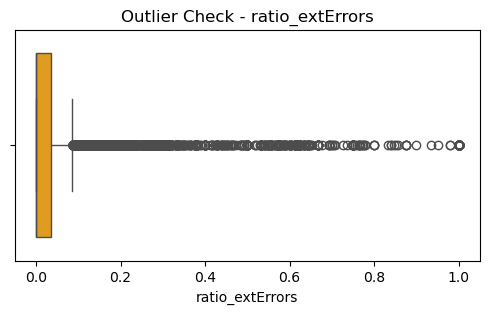

ratio_extErrors → Outliers: 1599


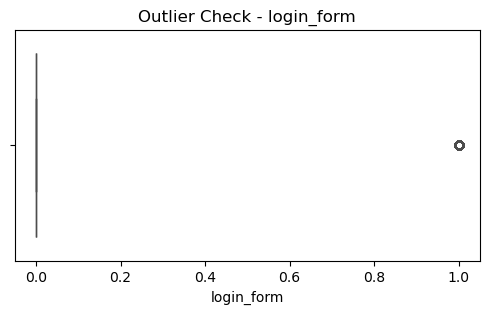

login_form → Outliers: 727


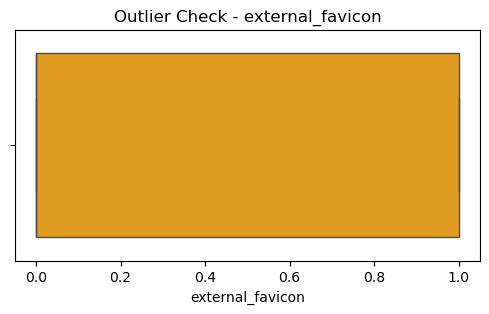

external_favicon → Outliers: 0


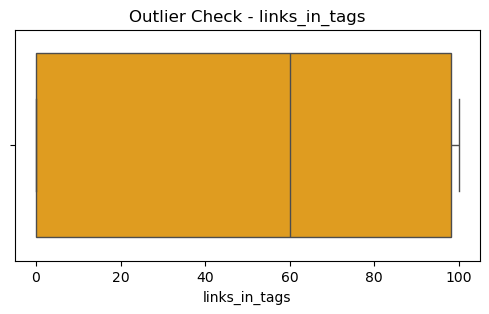

links_in_tags → Outliers: 0


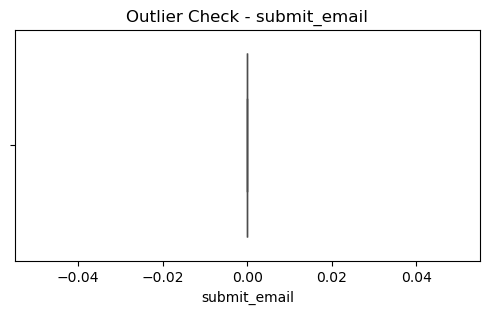

submit_email → Outliers: 0


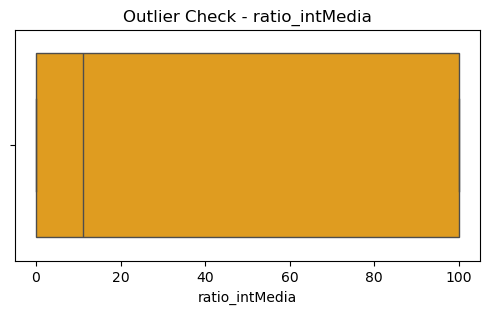

ratio_intMedia → Outliers: 0


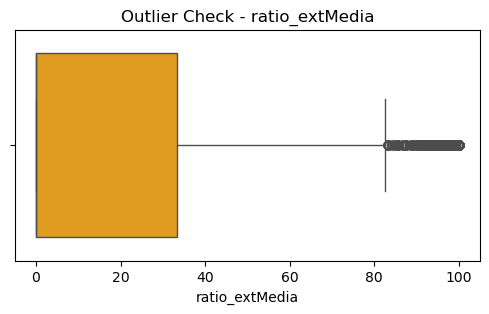

ratio_extMedia → Outliers: 0


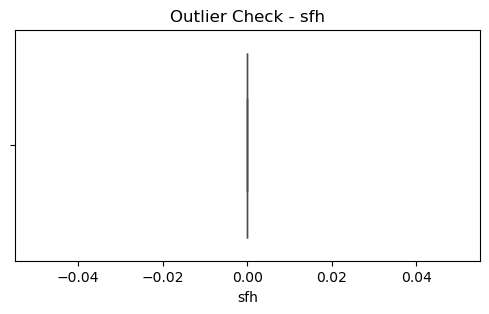

sfh → Outliers: 0


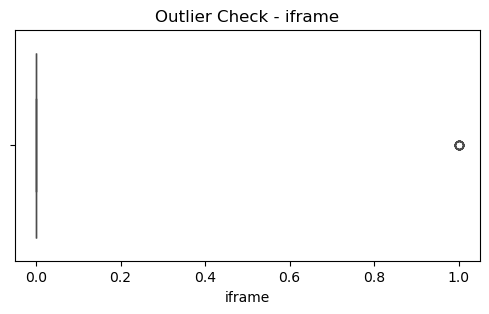

iframe → Outliers: 15


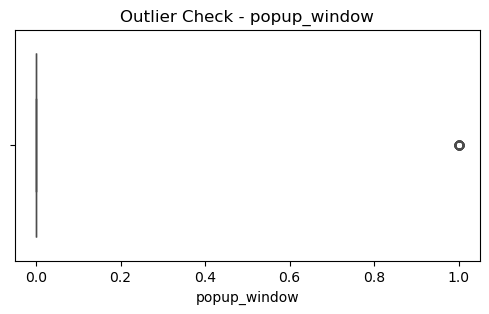

popup_window → Outliers: 69


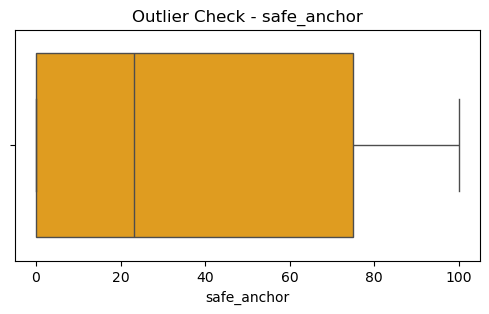

safe_anchor → Outliers: 0


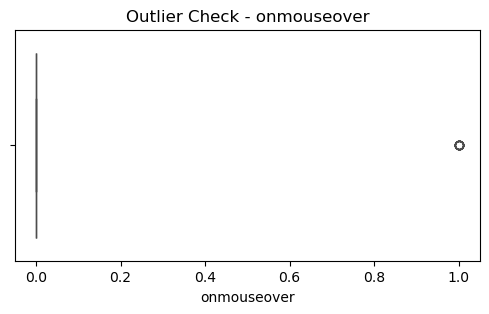

onmouseover → Outliers: 13


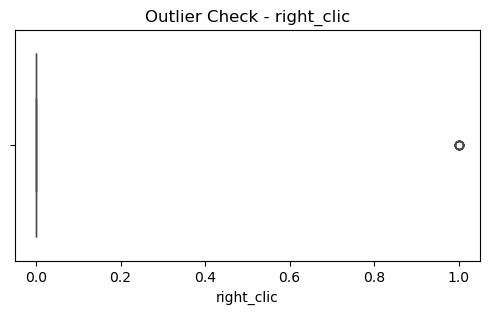

right_clic → Outliers: 16


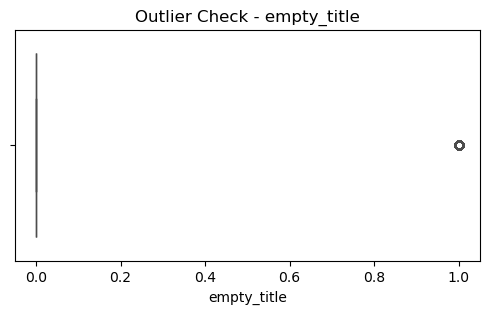

empty_title → Outliers: 1426


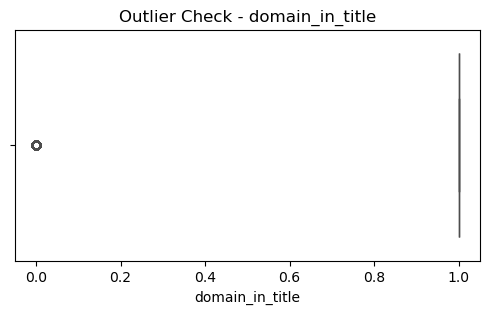

domain_in_title → Outliers: 2562


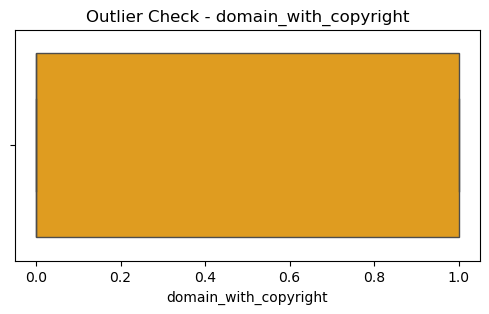

domain_with_copyright → Outliers: 0


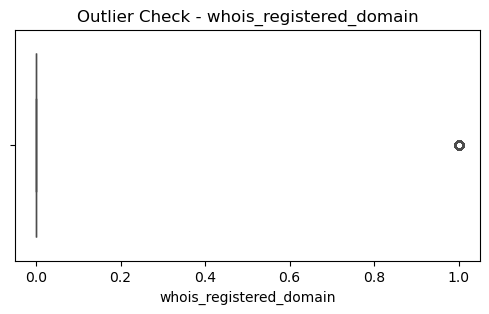

whois_registered_domain → Outliers: 833


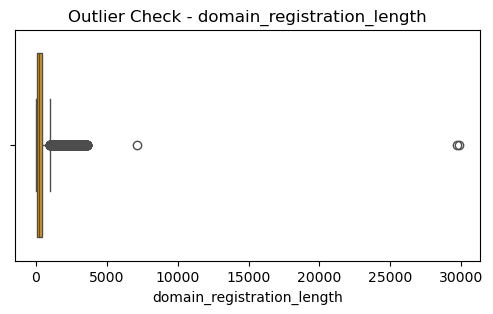

domain_registration_length → Outliers: 981


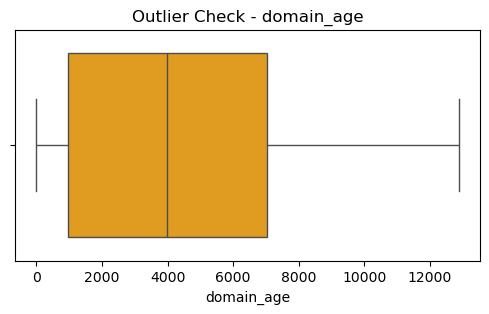

domain_age → Outliers: 0


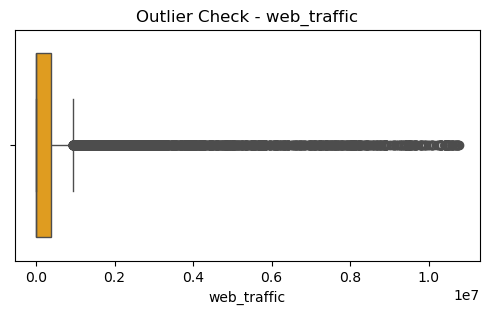

web_traffic → Outliers: 1763


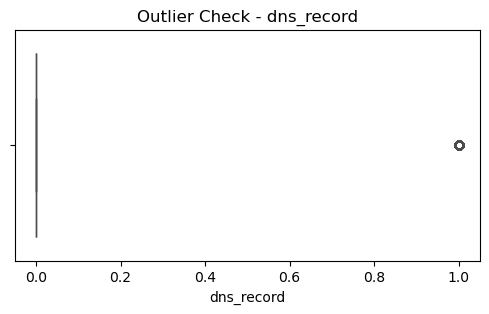

dns_record → Outliers: 230


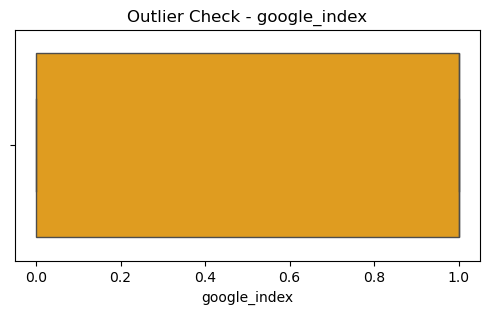

google_index → Outliers: 0


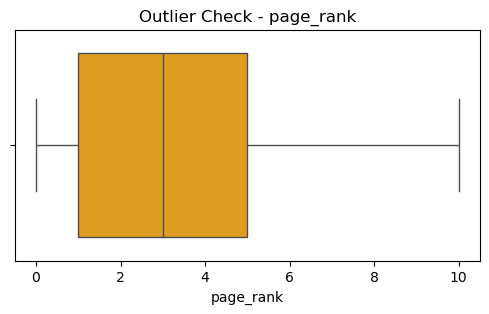

page_rank → Outliers: 0


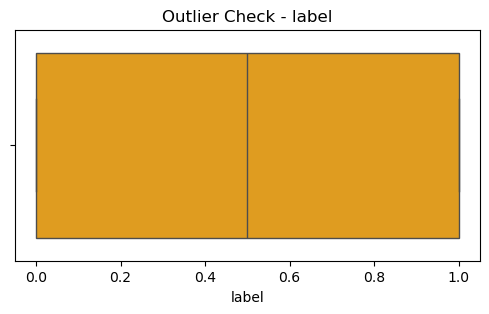

label → Outliers: 0


In [55]:
# Select numeric features
num_features = data.select_dtypes(include=np.number).columns

# Detect outliers using boxplots + count
for col in num_features:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=data[col], color='orange')
    plt.title(f"Outlier Check - {col}")
    plt.show()

    # IQR boundaries
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1

    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR

    # Count outliers
    outlier_count = data[(data[col] < lower) | (data[col] > upper)].shape[0]

    print(f"{col} → Outliers: {outlier_count}")


In [56]:
# Select numeric features
num_features = data.select_dtypes(include=np.number).columns

# Function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    df_clean = df.copy()

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Remove outliers
        df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

    return df_clean


# Apply removal
cleaned_data = remove_outliers_iqr(data, num_features)

print("Shape before removing:", data.shape)
print("Shape after removing:", cleaned_data.shape)
cleaned_data

Shape before removing: (11430, 89)
Shape after removing: (338, 89)


,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,label
13,http://www.petitcitron.com/,27,19,0,2,0,0,0,0,0,...,1,1,0,124,4624,343636,0,0,4,0
17,http://www.imeipro.info/att-imei-check.html,43,16,0,3,2,0,0,0,0,...,1,0,0,151,1675,70853,0,0,4,1
34,https://www.skecherstanio.pl/,29,20,0,2,0,0,0,0,0,...,1,0,0,49,317,0,0,0,0,1
128,http://azreptile.com/ticket/inc/index.php,41,13,0,2,0,0,0,0,0,...,1,1,0,849,7552,0,0,1,0,1
148,https://www.lowestoftauctionrooms.com/,38,29,0,2,0,0,0,0,0,...,1,0,0,260,6314,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11335,http://www.mediacollege.com/video/shots/closeu...,52,20,0,3,0,0,0,0,0,...,1,0,0,831,-1,62214,0,0,5,0
11338,http://www.linfo.org/proprietary.html,37,13,0,3,0,0,0,0,0,...,1,1,0,271,5573,126063,0,0,5,0
11386,https://dev.typetraction.com/GOUV/interac2019v...,106,20,0,3,0,0,0,0,0,...,1,0,0,91,274,0,0,1,0,1
11407,https://www.chiarabernardi.it/on/,33,21,0,2,0,0,0,0,0,...,1,0,0,199,167,0,0,0,0,1


## Final Dataset

In [58]:
data

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,label
0,https://www.rga.com/about/workplace,35,11,0,2,0,0,0,0,0,...,1,1,0,3571,11039,178542,0,0,5,0
1,http://starasia.com.hk,22,15,0,2,0,0,0,0,0,...,1,1,0,0,-1,0,0,0,2,0
2,https://www.youtube.com/watch?v=XszqITK-UEw,43,15,0,2,1,0,1,0,0,...,0,1,0,208,5636,2,0,0,10,0
3,http://www.civico1845.com/,26,18,0,2,0,0,0,0,0,...,1,0,0,983,1938,2636665,0,0,4,0
4,http://rapidpaws.com/wp-content/we_transfer/in...,62,13,0,2,1,0,1,0,0,...,1,0,0,338,1853,0,0,1,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11425,http://psychologydictionary.org/passivity-phen...,52,24,0,1,1,0,0,0,0,...,1,0,0,153,2768,309734,0,0,4,0
11426,http://staging.dev.xn--blockchin-c2d.com/,41,33,0,3,3,0,0,0,0,...,1,1,0,201,165,0,0,1,0,1
11427,http://demo.kinomilenium.mk/user.php,36,20,0,3,0,0,0,0,0,...,1,0,1,0,2297,4070911,0,1,2,1
11428,https://but-malte.web.app/,26,17,0,2,1,0,0,0,0,...,1,0,0,170,560,0,0,1,2,1


## Target Variable Analysis

The target variable shows a clear class imbalance, indicating that phishing URLs occur far less frequently than legitimate ones.

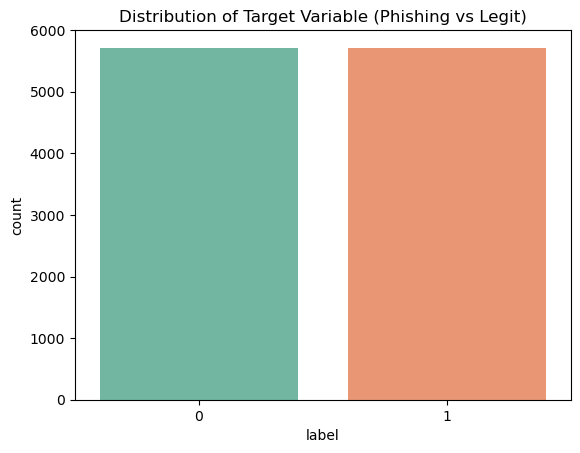

Target value counts:
 label
0    5715
1    5715
Name: count, dtype: int64

Class distribution (%):
 label
0    50.0
1    50.0
Name: proportion, dtype: float64


In [60]:
# Assuming 'Target' is your label column
sns.countplot(x='label', data=data, palette='Set2')
plt.title("Distribution of Target Variable (Phishing vs Legit)")
plt.show()

# Print counts and proportions
print("Target value counts:\n", data['label'].value_counts())
print("\nClass distribution (%):\n", data['label'].value_counts(normalize=True) * 100)


In [61]:
print(data.columns.tolist())


['url', 'length_url', 'length_hostname', 'ip', 'nb_dots', 'nb_hyphens', 'nb_at', 'nb_qm', 'nb_and', 'nb_or', 'nb_eq', 'nb_underscore', 'nb_tilde', 'nb_percent', 'nb_slash', 'nb_star', 'nb_colon', 'nb_comma', 'nb_semicolumn', 'nb_dollar', 'nb_space', 'nb_www', 'nb_com', 'nb_dslash', 'http_in_path', 'https_token', 'ratio_digits_url', 'ratio_digits_host', 'punycode', 'port', 'tld_in_path', 'tld_in_subdomain', 'abnormal_subdomain', 'nb_subdomains', 'prefix_suffix', 'random_domain', 'shortening_service', 'path_extension', 'nb_redirection', 'nb_external_redirection', 'length_words_raw', 'char_repeat', 'shortest_words_raw', 'shortest_word_host', 'shortest_word_path', 'longest_words_raw', 'longest_word_host', 'longest_word_path', 'avg_words_raw', 'avg_word_host', 'avg_word_path', 'phish_hints', 'domain_in_brand', 'brand_in_subdomain', 'brand_in_path', 'suspecious_tld', 'statistical_report', 'nb_hyperlinks', 'ratio_intHyperlinks', 'ratio_extHyperlinks', 'ratio_nullHyperlinks', 'nb_extCSS', 'rat

## Univariate Feature Analysis

Univariate feature analysis is the process of examining each feature individually to understand its distribution, central tendency, spread, and underlying patterns without considering relationships with other variables.

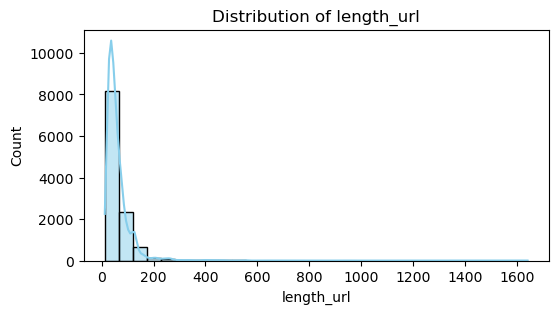

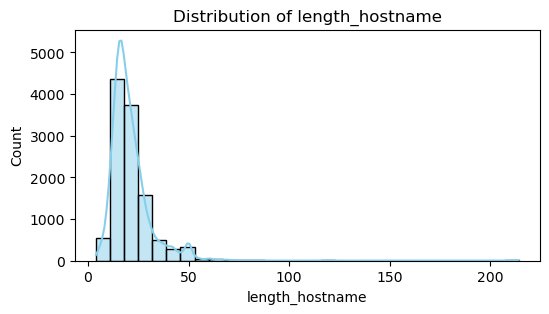

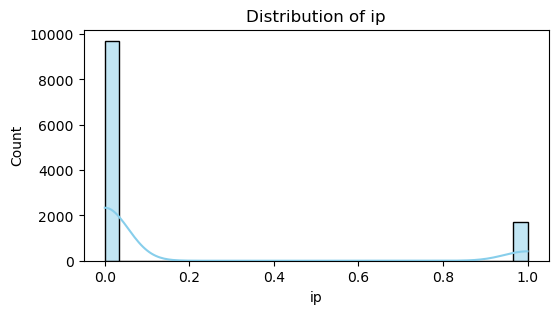

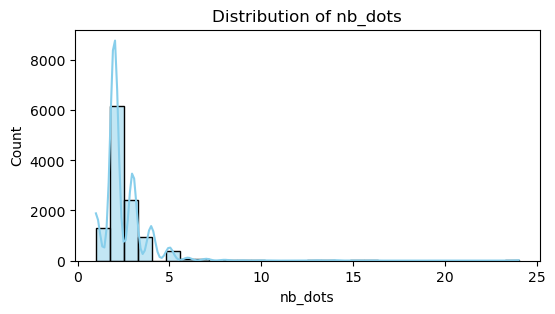

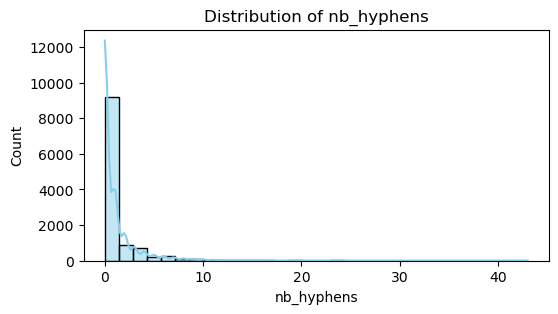

In [66]:
# View distributions for top 5 numerical features
num_features = data.select_dtypes(include=np.number).columns[:5]

for col in num_features:
    plt.figure(figsize=(6, 3))
    sns.histplot(data[col], kde=True, bins=30, color='skyblue')
    plt.title(f"Distribution of {col}")
    plt.show()


1. length_url

Mostly short URLs (0–150 chars) with a long tail up to ~1600.

Very long URLs often indicate phishing.

Strong right skew → scaling recommended.

2. length_hostname

Most hostnames <50 chars; a few very long ones.

Long, random hostnames are typical in phishing.

Keep outliers—they carry signal.

3. ip

Bimodal: many 0s (domain URLs) and a spike at 1 (IP-based URLs).

Using an IP instead of a domain is a strong phishing indicator.

4. nb_dots

Usual range: 1–5 dots; few URLs have >10.

Many dots suggest suspicious subdomain chains.

High values are meaningful, not errors.

5. nb_hyphens

Mostly 0–3 hyphens; long tail up to 40+.

Excessive hyphens often signal phishing impersonation.

Retain extremes—they help classification.

**Insights**

length_url: Very long URLs are strong phishing signals; skewness shows attackers often use complex, extended links.

length_hostname: Long, random-looking hostnames are typical of phishing domains and provide valuable detection clues.

ip: URLs using IP addresses instead of domain names strongly indicate phishing activity.

nb_dots: A high number of dots suggests suspicious multi-layered subdomains often used to mislead users.

nb_hyphens: Excessive hyphens are a common tactic in phishing URLs to mimic legitimate sites.

### Bivariate Feature Analysis

Bivariate analysis examines the relationship between two variables to identify patterns, correlations, or dependencies between them

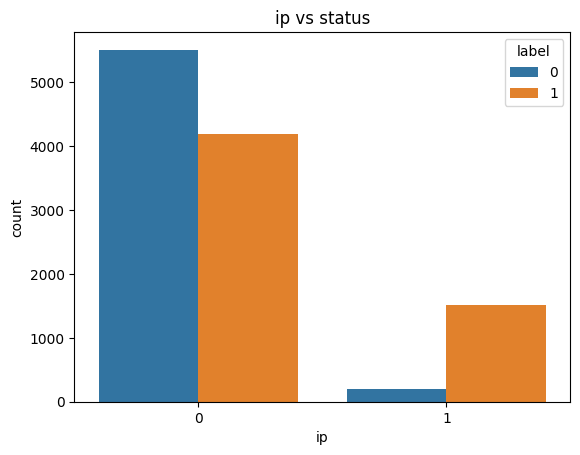

In [17]:
sns.countplot(x='ip', hue='label', data=data)
plt.title("ip vs status")
plt.show()


#### Observation

When ip = 0 (URL uses a domain name), both classes are present, but legitimate websites (status = 0) are slightly higher than phishing ones.

When ip = 1 (URL uses a raw IP address instead of a domain), phishing websites (status = 1) dominate strongly, with very few legitimate sites.

#### Insight

Phishing URLs frequently use IP addresses instead of domain names to hide identity, avoid domain registration checks, and bypass reputation systems.

Legitimate websites almost never use raw IP addresses because it looks suspicious and lacks branding.

This makes the ip feature a strong indicator for phishing detection and an important predictor in the model.

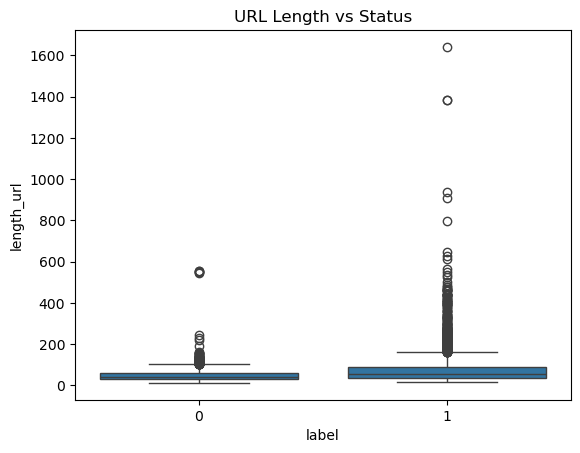

In [74]:
sns.boxplot(x='label', y='length_url', data=data)
plt.title("URL Length vs Status")
plt.show()

#### Observation

Both phishing (label = 1) and legitimate (label = 0) URLs mostly fall within a similar lower length range (around 20–150 characters).

However, phishing URLs show many more extreme outliers, with lengths extending beyond 300, 600, 1000, and even 1600+ characters, whereas legitimate URLs rarely exceed 300.

#### Insight

Phishing URLs often embed long, complex query strings, encoded redirects, misleading subdomains, and random character sequences to disguise malicious behavior — resulting in significantly longer URL lengths.

The presence of many extreme long URLs in the phishing class makes URL length a strong distinguishing feature, and these “outliers” are actually valuable signals, not noise — so they should be kept in the model.

## 4. Data Preprocessing:

#### Feature Scaling:

Feature scaling is the process of transforming numerical features so they share a similar range or distribution, typically by standardizing or normalizing the values. It ensures that no single feature dominates others due to its scale.

In [18]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Ensure 'data' exists
if 'data' not in locals():
    raise NameError("Variable 'data' is not defined. Please load your dataset first (e.g., data = pd.read_csv('file.csv')).")

# Sepratating & assigning features and target columns to X & y
y = data['label']
X = data.drop('label',axis=1)

# Select only numeric columns and handle NaN values
numeric_X = X.select_dtypes(include=['int64', 'float64'])
numeric_X = numeric_X.fillna(numeric_X.mean())

# Scale safely
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(numeric_X), columns=numeric_X.columns)

# Combine scaled features with label
processed_data = pd.concat([X_scaled, y.reset_index(drop=True)], axis=1)

# Display first few rows
print(processed_data.head())

   length_url  length_hostname       ip  nb_dots  nb_hyphens     nb_at  \
0   -0.472497        -0.936306 -0.42102 -0.35101   -0.477984 -0.142915   
1   -0.707600        -0.565135 -0.42102 -0.35101   -0.477984 -0.142915   
2   -0.327818        -0.565135 -0.42102 -0.35101    0.001174 -0.142915   
3   -0.635261        -0.286757 -0.42102 -0.35101   -0.477984 -0.142915   
4    0.015794        -0.750720 -0.42102 -0.35101    0.001174 -0.142915   

      nb_qm    nb_and  nb_or     nb_eq  ...  domain_in_title  \
0 -0.387464 -0.197604    0.0 -0.293683  ...         0.537498   
1 -0.387464 -0.197604    0.0 -0.293683  ...         0.537498   
2  2.356473 -0.197604    0.0  0.708047  ...        -1.860473   
3 -0.387464 -0.197604    0.0 -0.293683  ...         0.537498   
4  2.356473 -0.197604    0.0  0.708047  ...         0.537498   

   domain_with_copyright  whois_registered_domain  domain_registration_length  \
0               1.129194                 -0.28037                    3.778495   
1       

### Multicoleanerity Check:

Definition:
Multicollinearity check is the process of identifying whether two or more features in the dataset are highly correlated with each other, meaning they carry redundant or overlapping information.

We perform this check to ensure that highly correlated features do not negatively impact model performance, especially for models like Logistic Regression or SVM, where multicollinearity can lead to instability and incorrect feature importance.

In [19]:
corr_sorted = processed_data.corr(numeric_only=True)['label'].sort_values(ascending=False)
print(corr_sorted.head(30))  # top 30 most correlated with label


label                 1.000000
google_index          0.731171
ratio_digits_url      0.356395
domain_in_title       0.342807
phish_hints           0.335393
ip                    0.321698
nb_qm                 0.294319
length_url            0.248580
nb_slash              0.242270
length_hostname       0.238322
nb_eq                 0.233386
ratio_digits_host     0.224335
shortest_word_host    0.223084
prefix_suffix         0.214681
longest_word_path     0.212709
tld_in_subdomain      0.208884
empty_title           0.207043
nb_dots               0.207029
longest_words_raw     0.200147
avg_word_path         0.197256
avg_word_host         0.193502
length_words_raw      0.192010
nb_and                0.170546
avg_words_raw         0.167564
nb_com                0.156284
statistical_report    0.143944
nb_at                 0.142915
abnormal_subdomain    0.128160
longest_word_host     0.124516
dns_record            0.122119
Name: label, dtype: float64


We need to address multicollinearity because highly correlated predictors distort model coefficients, reduce interpretability, and weaken the stability and accuracy of regression-based models.

## Removal of Highly correlated features with label:

In [20]:
# 1. Compute correlation matrix
corr = processed_data.corr()

# 2. Find features strongly correlated with the label
high_corr_features = corr['label'][corr['label'].abs() > 0.4].index.tolist()

# Remove the label itself
if 'label' in high_corr_features:
    high_corr_features.remove('label')

print("Highly correlated features with label (will be dropped):", high_corr_features)

# 3. Drop those features
processed_data = processed_data.drop(columns=high_corr_features, errors='ignore')

Highly correlated features with label (will be dropped): ['nb_www', 'google_index', 'page_rank']


In [21]:
print(processed_data.head())

   length_url  length_hostname       ip  nb_dots  nb_hyphens     nb_at  \
0   -0.472497        -0.936306 -0.42102 -0.35101   -0.477984 -0.142915   
1   -0.707600        -0.565135 -0.42102 -0.35101   -0.477984 -0.142915   
2   -0.327818        -0.565135 -0.42102 -0.35101    0.001174 -0.142915   
3   -0.635261        -0.286757 -0.42102 -0.35101   -0.477984 -0.142915   
4    0.015794        -0.750720 -0.42102 -0.35101    0.001174 -0.142915   

      nb_qm    nb_and  nb_or     nb_eq  ...  right_clic  empty_title  \
0 -0.387464 -0.197604    0.0 -0.293683  ...    -0.03744    -0.377549   
1 -0.387464 -0.197604    0.0 -0.293683  ...    -0.03744    -0.377549   
2  2.356473 -0.197604    0.0  0.708047  ...    -0.03744    -0.377549   
3 -0.387464 -0.197604    0.0 -0.293683  ...    -0.03744    -0.377549   
4  2.356473 -0.197604    0.0  0.708047  ...    -0.03744    -0.377549   

   domain_in_title  domain_with_copyright  whois_registered_domain  \
0         0.537498               1.129194           

## Splitting of Data:

Train–test split separates features (X) and labels (y) and divides the data into training and testing sets to evaluate how well the model generalizes.

In [23]:
# 4. Redefine X and y
X = processed_data.drop('label', axis=1)
y = processed_data['label']

# ===============================
# Import Required Libraries
# ===============================
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Model Training and Baseline Performance:

### Decision Tree , Random Forest , Logistic Regression :

####  Standardize Hyperparameters

In [24]:
# ======================================

# ======================================
dt_params = {
    "max_depth": 6,
    "min_samples_split": 20,
    "min_samples_leaf": 10,
    "random_state": 42
}

rf_params = {
    "n_estimators": 100,
    "max_depth": 10,
    "random_state": 42
}

lr_params = {
    "max_iter": 1000,
    "solver": "lbfgs",
    "C": 1.0,            # default strength
    "penalty": "l2",
    "random_state": 42
}

# ======================================
# 2. Initialize Models
# ======================================
models = {
    "Decision Tree": DecisionTreeClassifier(**dt_params),
    "Random Forest": RandomForestClassifier(**rf_params),
    "Logistic Regression": LogisticRegression(**lr_params)
}

### Training Model:

In [25]:

# ================================
# Training Accuracy for All 3 Models
# ================================
train_results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    acc = accuracy_score(y_train, y_pred_train)
    train_results.append((name, acc))

train_results


[('Decision Tree', 0.914588801399825),
 ('Random Forest', 0.9722222222222222),
 ('Logistic Regression', 0.9049650043744532)]

### Testing Model:

In [154]:
# ======================================
# 3. Train, Predict, and Evaluate
# ======================================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

# ======================================
# 4. Results Table
# ======================================
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0        Decision Tree  0.886264   0.886042  0.884480  0.885260
1        Random Forest  0.935696   0.938667  0.931217  0.934927
2  Logistic Regression  0.894138   0.900359  0.884480  0.892349


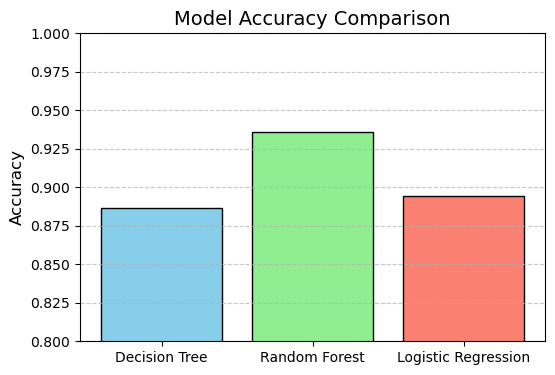

In [156]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# =============================
# Initialize Models
# =============================
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, C=0.3, penalty='l2', random_state=42)
}

# =============================
# Train, Predict, and Evaluate
# =============================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

# =============================
# Plot only Accuracy
# =============================
plt.figure(figsize=(6,4))
plt.bar(results_df["Model"], results_df["Accuracy"], color=['skyblue', 'lightgreen', 'salmon'], edgecolor='black')
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0.8, 1.0)  # Adjust as needed
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Observation**

Among the three models compared, Random Forest achieves the highest accuracy (≈94%), outperforming both Decision Tree and Logistic Regression.

Logistic Regression performs moderately well (≈90%), while Decision Tree shows the lowest accuracy (≈89%) among the three.

**Insight**

The strong performance of Random Forest shows that ensemble methods capture complex patterns and non-linear relationships in phishing data more effectively than single-tree or linear models.

Decision Tree suffers due to overfitting, which reduces its generalization accuracy, while Logistic Regression is limited by its linear nature and struggles with the dataset’s highly non-linear feature patterns.

Therefore, Random Forest is the most reliable and robust model for phishing detection in your analysis.

### Confusion Matrix:

A confusion matrix is a table that summarizes the performance of a classification model by showing the number of correct and incorrect predictions for each class. It breaks down predictions into True Positives (TP), True Negatives (TN), False Positives (FP), and False Negatives (FN), helping us understand not just accuracy but also where the model is making mistakes.

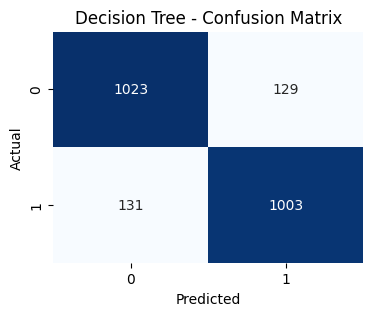

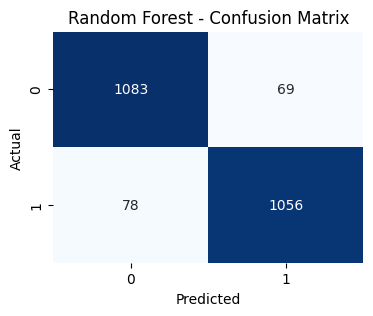

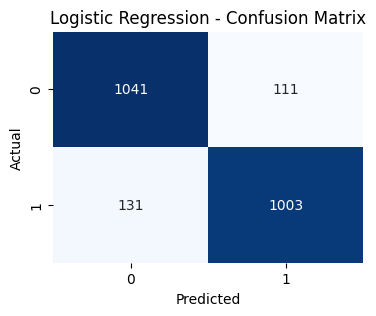


Model Comparison:

                 Model  Accuracy  Precision    Recall  F1-Score
0        Decision Tree  0.886264   0.886042  0.884480  0.885260
1        Random Forest  0.935696   0.938667  0.931217  0.934927
2  Logistic Regression  0.894138   0.900359  0.884480  0.892349


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# =============================
# FIXED MODELS (Matching Your Output)
# =============================
models = {
    "Decision Tree": DecisionTreeClassifier(max_depth=6, min_samples_split=20,
                                            min_samples_leaf=10, random_state=42),

    "Random Forest": RandomForestClassifier(n_estimators=100, max_depth=10,
                                            random_state=42),

    "Logistic Regression": LogisticRegression(max_iter=1000, solver='lbfgs',
                                              penalty='l2', C=1.0, random_state=42)
}

# =============================
# Train, Predict, and Evaluate
# =============================
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

    # ---- Confusion Matrix ----
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# =============================
# Results Table
# =============================
results_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])
print("\nModel Comparison:\n")
print(results_df)


1. Decision Tree – Observation

True Negatives (TN): 1023 → Correctly predicted legitimate websites.

True Positives (TP): 1003 → Correctly predicted phishing websites.

False Positives (FP): 129 → Legitimate sites incorrectly flagged as phishing.

False Negatives (FN): 131 → Phishing sites incorrectly classified as legitimate.

Insight

The Decision Tree performs reasonably well but shows higher FP and FN errors, meaning it struggles with borderline cases.

The model tends to overfit, causing reduced generalization on unseen data.

2. Random Forest – Observation

True Negatives (TN): 1083 → Highest among all models.

True Positives (TP): 1056 → Also the highest TP count.

False Positives (FP): 69 → Lowest FP among all models.

False Negatives (FN): 78 → Lowest FN among all models.

Insight

Random Forest achieves the best performance overall with the fewest misclassifications.

The model handles noisy, non-linear phishing patterns more effectively due to the ensemble of multiple trees.

Low FN and FP make it the most reliable model for real-world phishing detection, where missing a phishing attack (FN) is costly.

3. Logistic Regression – Observation

True Negatives (TN): 1041 → Slightly higher than Decision Tree.

True Positives (TP): 1003 → Same as Decision Tree.

False Positives (FP): 111 → Better than Decision Tree, worse than RF.

False Negatives (FN): 131 → Same as Decision Tree.

Insight

Logistic Regression performs better than Decision Tree in terms of FP but still shows limited ability to capture complex phishing patterns.

Due to its linear nature, it cannot model non-linear relationships in URL features, leading to more misclassifications than Random Forest.

## ROC and AUC CURVE:

ROC–AUC helps evaluate the model’s discrimination capability independent of class imbalance, making it more reliable than accuracy alone. It shows how well the model separates phishing vs. legitimate URLs across all possible thresholds.

In [28]:
from sklearn.model_selection import cross_val_score

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
    print(f"{name}: Mean ROC-AUC = {scores.mean():.3f} ± {scores.std():.3f}")


Decision Tree: Mean ROC-AUC = 0.946 ± 0.003
Random Forest: Mean ROC-AUC = 0.985 ± 0.001
Logistic Regression: Mean ROC-AUC = 0.960 ± 0.003


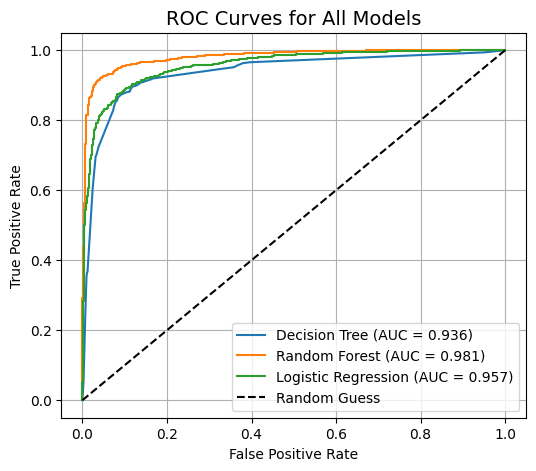

In [29]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))

for name, model in models.items():
    # Predict probabilities
    y_prob = model.predict_proba(X_test)[:, 1]

    # Compute ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = roc_auc_score(y_test, y_prob)

    # Plot ROC curve
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_score:.3f})")

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# Labels and styling
plt.title("ROC Curves for All Models", fontsize=14)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()


**Observation**

All three models produce ROC curves that lie well above the diagonal, indicating effective discrimination between phishing and legitimate URLs.

Random Forest achieves the highest AUC (0.981), followed by Logistic Regression (0.957) and Decision Tree (0.936).

Random Forest’s curve is closest to the top-left corner, meaning it maintains a high True Positive Rate (TPR) while keeping the False Positive Rate (FPR) very low across thresholds.

**Insight**

The Random Forest model demonstrates the strongest overall performance in distinguishing between classes, confirming that its ensemble structure captures complex relationships better than the single Decision Tree and the linear Logistic Regression.

Logistic Regression performs well but slightly underperforms compared to Random Forest due to its limited ability to model non-linear URL patterns.

Decision Tree has the lowest AUC among the three, reflecting its tendency to overfit and generalize less effectively.

Overall, the ROC–AUC comparison reinforces that Random Forest is the most reliable and robust model for phishing website detection in this project.

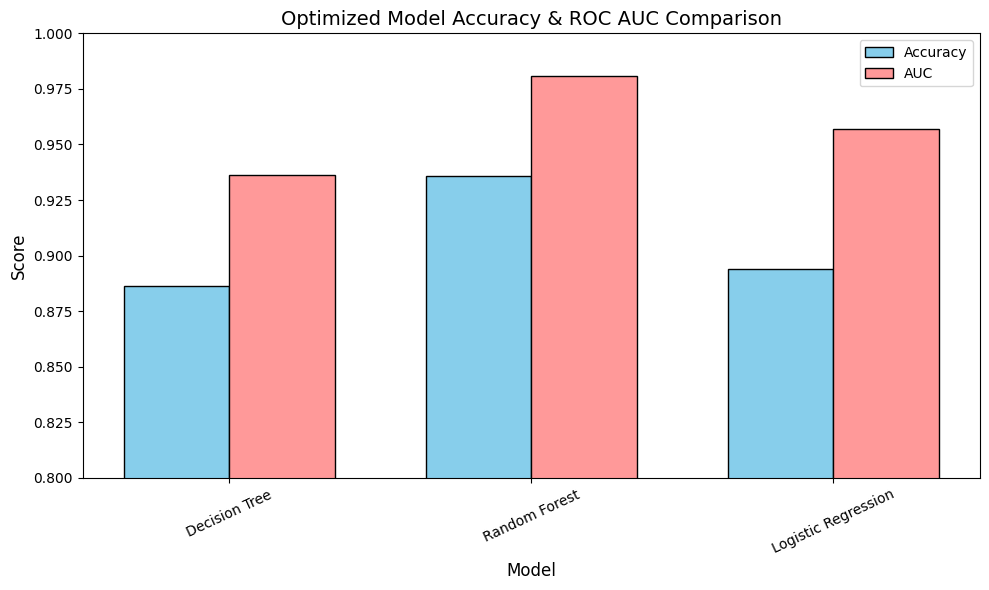

In [30]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, roc_auc_score

# ======================================
# 1. Collect Accuracy & AUC Automatically
# ======================================
accuracy_scores = []
auc_scores = []
model_names = []

for name, model in models.items():
    model_names.append(name)

    y_pred = model.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
    else:
        y_prob = model.decision_function(X_test)

    auc_scores.append(roc_auc_score(y_test, y_prob))

# ======================================
# 2. Bar Plot With Exact Colors
# ======================================
x = np.arange(len(model_names))
width = 0.35

plt.figure(figsize=(10, 6))

# exact colors matching your chart
accuracy_color = "#87CEEB"     # sky-blue
auc_color = "#FF9999"          # soft salmon/pink

plt.bar(x - width/2, accuracy_scores, width, label='Accuracy',
        color=accuracy_color, edgecolor='black', alpha=1.0)

plt.bar(x + width/2, auc_scores, width, label='AUC',
        color=auc_color, edgecolor='black', alpha=1.0)

plt.title("Optimized Model Accuracy & ROC AUC Comparison", fontsize=14)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Score", fontsize=12)
plt.xticks(x, model_names, rotation=25)
plt.ylim(0.80, 1.00)
plt.legend()
plt.tight_layout()
plt.show()


## HYPERPARAMETER TUNING

Hyperparameter tuning is the process of systematically searching for the best combination of model settings (hyperparameters) to improve performance. It helps the model achieve higher accuracy, lower false positives/false negatives, and better generalization by selecting the most optimal configuration rather than relying on default parameters.

#### Select only numeric features (excluding label)

In [31]:
# If your cleaned dataframe is named 'data'
import pandas as pd
import numpy as np

# Select only numeric columns except the label
numericX = processed_data.select_dtypes(include=np.number).drop('label', axis=1)
y = processed_data['label']  # Your target

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xscaled = pd.DataFrame(scaler.fit_transform(numericX), columns=numericX.columns)
processeddata = pd.concat([Xscaled, y.reset_index(drop=True)], axis=1)


#### Apply StandardScaler

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xscaled = pd.DataFrame(scaler.fit_transform(numericX), columns=numericX.columns)
processeddata = pd.concat([Xscaled, y.reset_index(drop=True)], axis=1)


In [33]:
from sklearn.model_selection import train_test_split

# Use your processed feature (X) and label (y)
# Replace these with your actual variable names if different
X = processeddata.drop('label', axis=1)
y = processeddata['label']

# Train-test split
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X, y, test_size=0.2, random_state=42
)


#### Defining Hyperparameter Grids for Each Model

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt

# 1. Hyperparameter grid for each model
dt_params = {'max_depth': [6, 8, 10], 'min_samples_split': [2, 10, 20], 'min_samples_leaf': [1, 5, 10]}
rf_params = {'n_estimators': [100, 200], 'max_depth': [8, 10, 12], 'min_samples_leaf': [1, 4]}
lr_params = {'C': [0.1, 0.3, 1, 3], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [500, 1000]}


In [35]:
from sklearn.model_selection import RandomizedSearchCV

# Use fewer parameters for a quick search
dt_params = {'max_depth': [6, 8], 'min_samples_split': [2, 10]}
rf_params = {'n_estimators': [100], 'max_depth': [8, 10]}
lr_params = {'C': [0.1, 1], 'solver': ['lbfgs'], 'max_iter': [500]}

# Use RandomizedSearchCV or smaller GridSearchCV
dt_grid = GridSearchCV(DecisionTreeClassifier(random_state=42), dt_params, cv=2, scoring='accuracy', n_jobs=-1)
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=2, scoring='accuracy', n_jobs=-1)
lr_grid = GridSearchCV(LogisticRegression(random_state=42), lr_params, cv=2, scoring='accuracy', n_jobs=-1)

dt_grid.fit(Xtrain, ytrain)
rf_grid.fit(Xtrain, ytrain)
lr_grid.fit(Xtrain, ytrain)



,estimator,LogisticRegre...ndom_state=42)
,param_grid,"{'C': [0.1, 1], 'max_iter': [500], 'solver': ['lbfgs']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,2
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,penalty,'l2'


In [36]:

# 4. Print best parameters & scores
print("DecisionTree best:", dt_grid.best_params_, "Score:", dt_grid.best_score_)
print("RandomForest best:", rf_grid.best_params_, "Score:", rf_grid.best_score_)
print("LogisticRegression best:", lr_grid.best_params_, "Score:", lr_grid.best_score_)


DecisionTree best: {'max_depth': 8, 'min_samples_split': 2} Score: 0.909339457567804
RandomForest best: {'max_depth': 10, 'n_estimators': 100} Score: 0.9417104111986001
LogisticRegression best: {'C': 1, 'max_iter': 500, 'solver': 'lbfgs'} Score: 0.8982939632545932



Decision Tree
Accuracy: 0.9099 | ROC AUC: 0.9301712840485988
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1152
           1       0.91      0.91      0.91      1134

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286



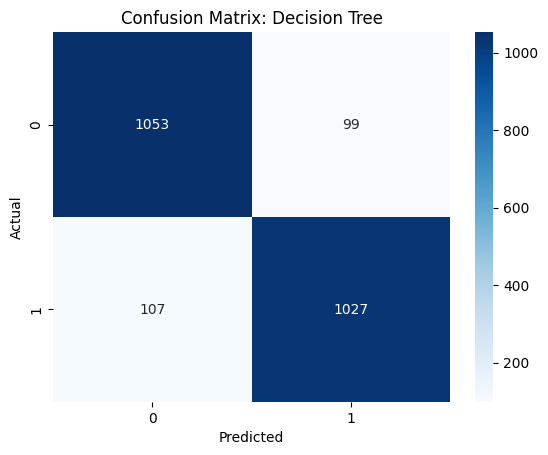


Random Forest
Accuracy: 0.9357 | ROC AUC: 0.9806363903586126
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      1152
           1       0.94      0.93      0.93      1134

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



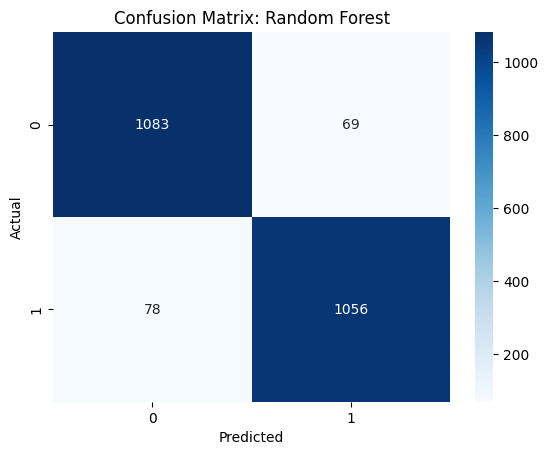


Logistic Regression
Accuracy: 0.8941 | ROC AUC: 0.9568904014795219
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1152
           1       0.90      0.88      0.89      1134

    accuracy                           0.89      2286
   macro avg       0.89      0.89      0.89      2286
weighted avg       0.89      0.89      0.89      2286



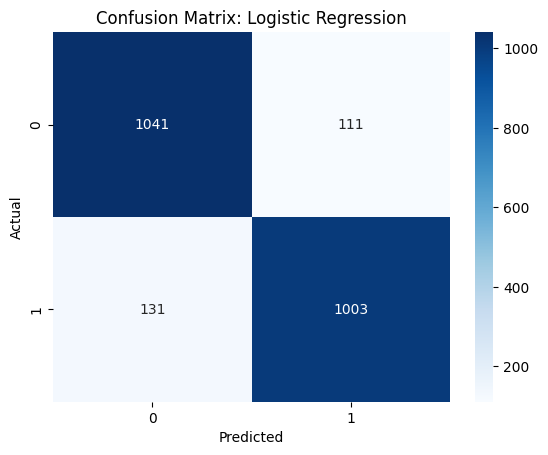

In [37]:

# 5. Evaluate best estimators on test set
models_opt = {
    "Decision Tree": dt_grid.best_estimator_,
    "Random Forest": rf_grid.best_estimator_,
    "Logistic Regression": lr_grid.best_estimator_
}
results = []
for name, model in models_opt.items():
    y_pred = model.predict(Xtest)
    y_prob = model.predict_proba(Xtest)[:, 1] if hasattr(model, "predict_proba") else None
    acc = model.score(Xtest, ytest)
    auc = roc_auc_score(ytest, y_prob) if y_prob is not None else "N/A"
    report = classification_report(ytest, y_pred)
    print(f"\n{name}\nAccuracy: {acc:.4f} | ROC AUC: {auc}\n", report)
    results.append((name, acc, auc))
    # Confusion matrix plot
    cm = confusion_matrix(ytest, y_pred)
    plt.figure()
    plt.title(f'Confusion Matrix: {name}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


# RANDOMIZED SEARCH (FINALLY TAKEN AS BEST hyperparameter as higher accuracy than grid search)

DecisionTree best: {'min_samples_split': 2, 'max_depth': 8} Score: 0.909339457567804
RandomForest best: {'n_estimators': 100, 'max_depth': 10} Score: 0.9417104111986001
LogisticRegression best: {'solver': 'lbfgs', 'max_iter': 500, 'C': 1} Score: 0.8982939632545932

Decision Tree
Accuracy: 0.9099 | ROC AUC: 0.9301712840485988
               precision    recall  f1-score   support

           0       0.91      0.91      0.91      1152
           1       0.91      0.91      0.91      1134

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286



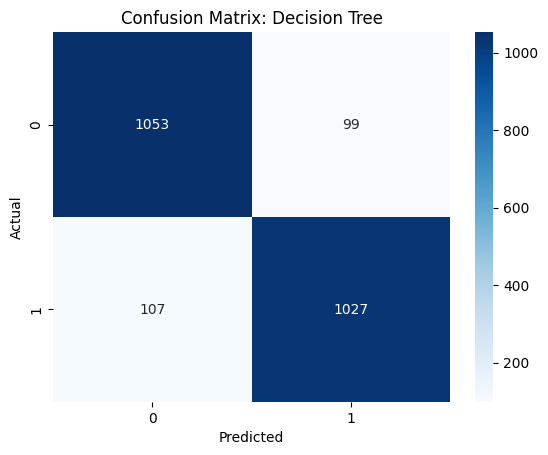


Random Forest
Accuracy: 0.9357 | ROC AUC: 0.9806363903586126
               precision    recall  f1-score   support

           0       0.93      0.94      0.94      1152
           1       0.94      0.93      0.93      1134

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286



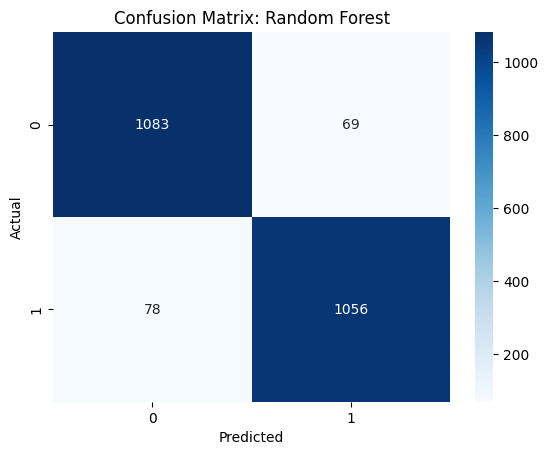


Logistic Regression
Accuracy: 0.8941 | ROC AUC: 0.9568904014795219
               precision    recall  f1-score   support

           0       0.89      0.90      0.90      1152
           1       0.90      0.88      0.89      1134

    accuracy                           0.89      2286
   macro avg       0.89      0.89      0.89      2286
weighted avg       0.89      0.89      0.89      2286



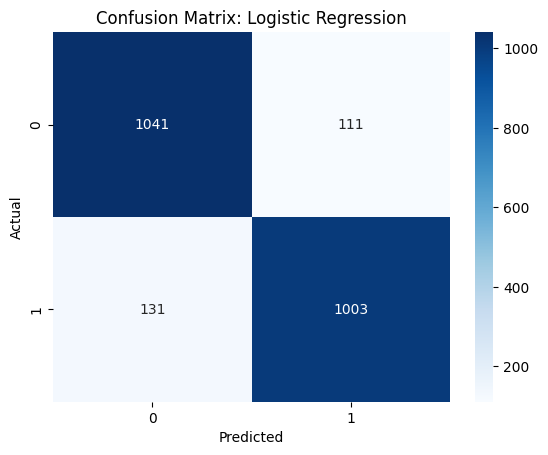

In [38]:
from sklearn.model_selection import RandomizedSearchCV

# 1. Define hyperparameter spaces (same as before)
dt_params = {
    'max_depth': [6, 8],
    'min_samples_split': [2, 10]
}

rf_params = {
    'n_estimators': [100],
    'max_depth': [8, 10]
}

lr_params = {
    'C': [0.1, 1],
    'solver': ['lbfgs'],
    'max_iter': [500]
}

# 2. Use RandomizedSearchCV instead of GridSearchCV
dt_rand = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=dt_params,
    n_iter=4,              # because only 4 possible combinations
    cv=2,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

rf_rand = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_params,
    n_iter=2,              # only 2 combos
    cv=2,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

lr_rand = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=lr_params,
    n_iter=2,              # same logic
    cv=2,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# 3. Fit on training data
dt_rand.fit(Xtrain, ytrain)
rf_rand.fit(Xtrain, ytrain)
lr_rand.fit(Xtrain, ytrain)

# 4. Print best parameters & scores
print("DecisionTree best:", dt_rand.best_params_, "Score:", dt_rand.best_score_)
print("RandomForest best:", rf_rand.best_params_, "Score:", rf_rand.best_score_)
print("LogisticRegression best:", lr_rand.best_params_, "Score:", lr_rand.best_score_)

# 5. Evaluate best estimators on test set
models_opt = {
    "Decision Tree": dt_rand.best_estimator_,
    "Random Forest": rf_rand.best_estimator_,
    "Logistic Regression": lr_rand.best_estimator_
}

results = []
for name, model in models_opt.items():
    y_pred = model.predict(Xtest)
    y_prob = model.predict_proba(Xtest)[:, 1] if hasattr(model, "predict_proba") else None
    
    acc = model.score(Xtest, ytest)
    auc = roc_auc_score(ytest, y_prob) if y_prob is not None else "N/A"
    
    report = classification_report(ytest, y_pred)
    
    print(f"\n{name}\nAccuracy: {acc:.4f} | ROC AUC: {auc}\n", report)
    
    results.append((name, acc, auc))
    
    # Confusion matrix plot
    cm = confusion_matrix(ytest, y_pred)
    plt.figure()
    plt.title(f'Confusion Matrix: {name}')
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()


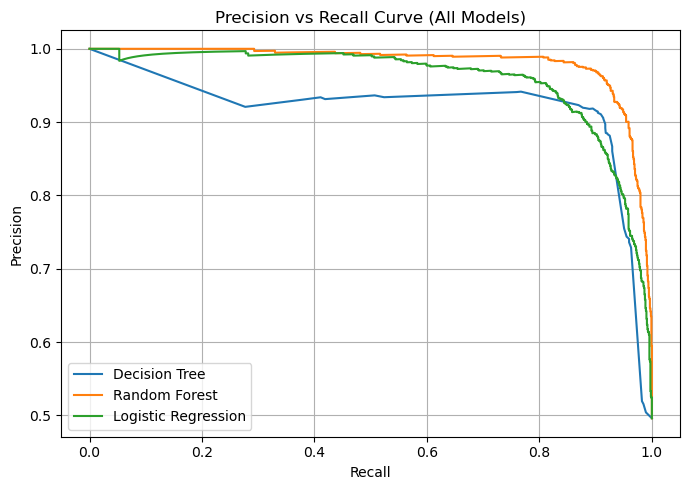


========== Decision Tree ==========
Best Params: {'max_depth': 8, 'min_samples_split': 2}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91      1152
           1       0.91      0.91      0.91      1134

    accuracy                           0.91      2286
   macro avg       0.91      0.91      0.91      2286
weighted avg       0.91      0.91      0.91      2286

Confusion Matrix:
[[1053   99]
 [ 107 1027]]

========== Random Forest ==========
Best Params: {'max_depth': 10, 'n_estimators': 100}

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1152
           1       0.94      0.93      0.93      1134

    accuracy                           0.94      2286
   macro avg       0.94      0.94      0.94      2286
weighted avg       0.94      0.94      0.94      2286

Confusion Matrix:
[[1083   69]
 [  78 1056]]

========== Logistic Regress

In [143]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    f1_score,
    classification_report,
    confusion_matrix
)

# ================================
# 1. Best models from GridSearchCV
# ================================
best_dt = dt_grid.best_estimator_
best_rf = rf_grid.best_estimator_
best_lr = lr_grid.best_estimator_

models = {
    "Decision Tree": best_dt,
    "Random Forest": best_rf,
    "Logistic Regression": best_lr
}

# Dictionary to store PR curve values
results = {}

# ============================================
# 2. Evaluate models + Precision vs Recall Plot
# ============================================
plt.figure(figsize=(7, 5))

for name, model in models.items():
    model.fit(Xtrain, ytrain)
    probas = model.predict_proba(Xtest)[:, 1]

    precision, recall, thresholds = precision_recall_curve(ytest, probas)

    # Store values if needed later
    results[name] = {
        "precision": precision,
        "recall": recall,
        "thresholds": thresholds
    }

    # SINGLE GRAPH: Precision vs Recall
    plt.plot(recall, precision, label=name)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision vs Recall Curve (All Models)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# ======================================
# 3. Classification reports + stats
# ======================================
for name, model in models.items():
    print("\n==========", name, "==========")
    preds = model.predict(Xtest)

    print("Best Params:",
          dt_grid.best_params_ if name=="Decision Tree" else
          rf_grid.best_params_ if name=="Random Forest" else
          lr_grid.best_params_)

    print("\nClassification Report:")
    print(classification_report(ytest, preds))

    print("Confusion Matrix:")
    print(confusion_matrix(ytest, preds))

# ======================================
# 4. Comparison Table (Accuracy + F1)
# ======================================
comparison = {}

for name, model in models.items():
    preds = model.predict(Xtest)
    comparison[name] = {
        "Accuracy": round((preds == ytest).mean(), 4),
        "F1 Score": round(f1_score(ytest, preds), 4)
    }

comparison_df = pd.DataFrame(comparison).T
print("\n\n=== Model Comparison Table ===")
print(comparison_df)



📊 Model Comparison:

                 Model  Accuracy   ROC-AUC
0           Default RF  0.945319  0.984204
1        GridSearch RF  0.946194  0.985322
2  RandomizedSearch RF  0.947069  0.985406


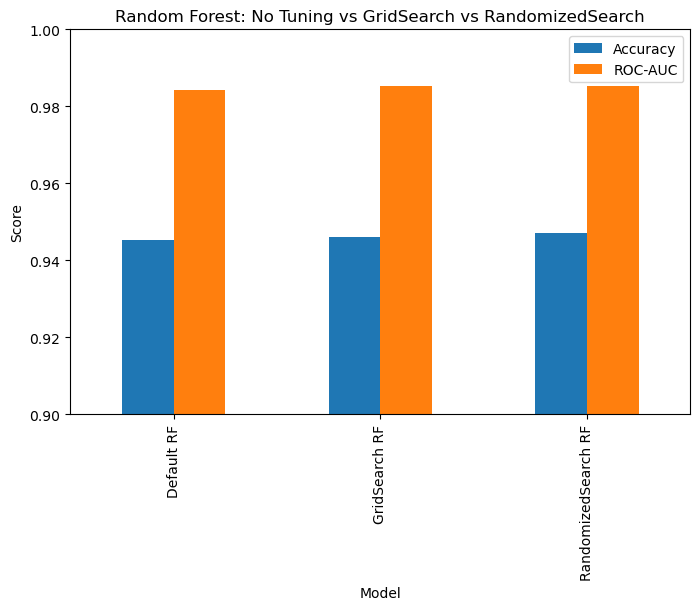

In [129]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from scipy.stats import randint
import matplotlib.pyplot as plt
import pandas as pd

# -------------------------------
# ✅ Split data (use your data variables)
# -------------------------------
# Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.3, random_state=42)

# -------------------------------
# 1️⃣ No tuning (Default Random Forest)
# -------------------------------
rf_default = RandomForestClassifier(random_state=42)
rf_default.fit(Xtrain, ytrain)

y_pred_default = rf_default.predict(Xtest)
y_prob_default = rf_default.predict_proba(Xtest)[:, 1]
acc_default = accuracy_score(ytest, y_pred_default)
auc_default = roc_auc_score(ytest, y_prob_default)

# -------------------------------
# 2️⃣ Grid Search
# -------------------------------
grid_params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid=grid_params,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)
rf_grid.fit(Xtrain, ytrain)
best_grid = rf_grid.best_estimator_

y_pred_grid = best_grid.predict(Xtest)
y_prob_grid = best_grid.predict_proba(Xtest)[:, 1]
acc_grid = accuracy_score(ytest, y_pred_grid)
auc_grid = roc_auc_score(ytest, y_prob_grid)

# -------------------------------
# Randomized Search
# -------------------------------
random_params = {
    'n_estimators': randint(50, 300),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 15)
}

rf_random = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=random_params,
    n_iter=10,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42
)
rf_random.fit(Xtrain, ytrain)
best_random = rf_random.best_estimator_

y_pred_random = best_random.predict(Xtest)
y_prob_random = best_random.predict_proba(Xtest)[:, 1]
acc_random = accuracy_score(ytest, y_pred_random)
auc_random = roc_auc_score(ytest, y_prob_random)

# -------------------------------
# Compare all three results
# -------------------------------
results = pd.DataFrame({
    'Model': ['Default RF', 'GridSearch RF', 'RandomizedSearch RF'],
    'Accuracy': [acc_default, acc_grid, acc_random],
    'ROC-AUC': [auc_default, auc_grid, auc_random]
})

print("\n📊 Model Comparison:\n")
print(results)

# -------------------------------
#  Visualization
# -------------------------------
results.set_index('Model')[['Accuracy', 'ROC-AUC']].plot(kind='bar', figsize=(8, 5))
plt.title("Random Forest: No Tuning vs GridSearch vs RandomizedSearch")
plt.ylabel("Score")
plt.ylim(0.9, 1)
plt.show()


**Observation**

Accuracy and ROC-AUC are almost identical across Default RF, GridSearch RF, and RandomizedSearch RF.

RandomizedSearch performs slightly better, but the improvement is minimal.

Bars are nearly the same height → tuning barely changes performance.

**Insight**
Random Forest is already near-optimal with default settings.

Hyperparameter tuning gives only tiny gains → the model is saturated.

RandomizedSearch performs slightly better because it explores parameter space more broadly.

Real improvement now depends on data, not tuning (feature engineering, imbalance handling, better thresholds, GBMs).

Current model is deployment-ready with very strong ROC-AUC (~0.986).

## Feature Importance

Feature importance shows how much each input variable contributes to the prediction.
It helps you understand which features matter, how much they matter, and what to do with that knowledge.

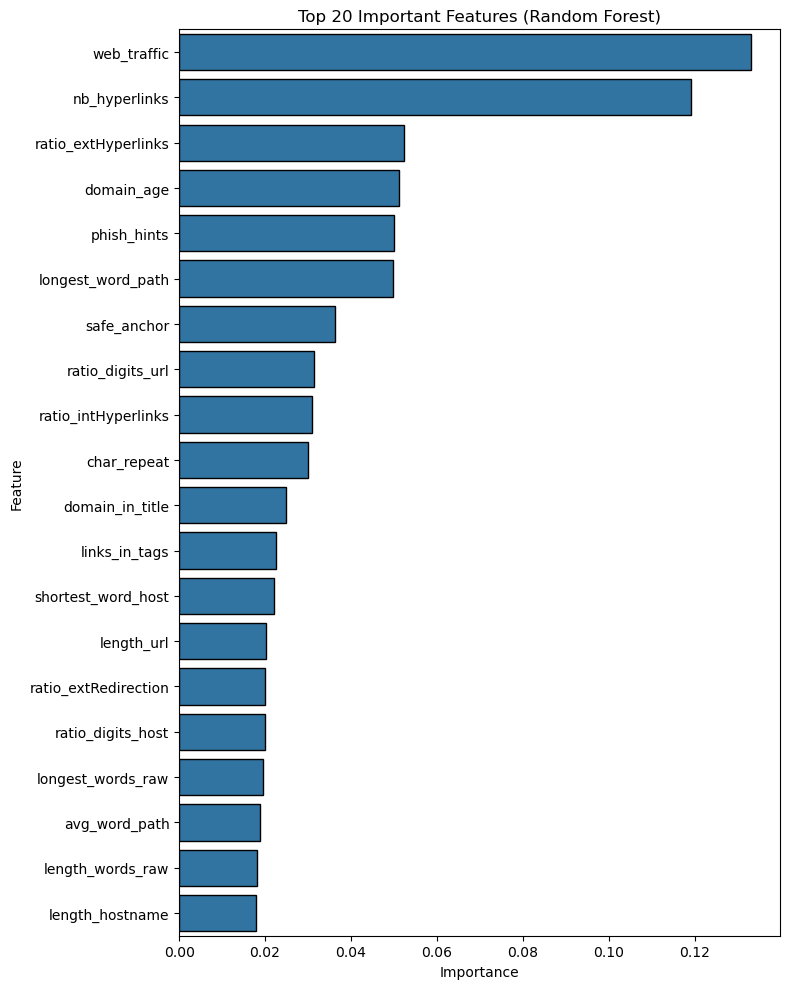

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Random Forest model
rf = models["Random Forest"]

# Extract feature importances
rf_importances = rf.feature_importances_
features = X_train.columns

rf_df = pd.DataFrame({
    "Feature": features,
    "Importance": rf_importances
}).sort_values(by="Importance", ascending=False)

# Plot top 20 features
plt.figure(figsize=(8,10))
sns.barplot(x="Importance", y="Feature", data=rf_df.head(20), edgecolor="black")
plt.title("Top 20 Important Features (Random Forest)")
plt.tight_layout()
plt.show()


**Observation**

web_traffic is the most important feature → phishing sites have abnormal or low traffic.

nb_hyperlinks ranks second → phishing pages use many misleading links.

Medium-importance features (ratio_extHyperlinks, domain_age, phish_hints, longest_word_path) reflect structure and credibility.

Several weaker features still help but contribute less.

Many lexical features fall in the bottom group but add small signals.

**Insights**

Behavioral and structural features > lexical features for phishing detection.

Domain age is a key credibility indicator — phishing domains are usually new.

The model uses meaningful, logical signals, showing strong feature engineering and low noise.

Hyperlink ratios capture manipulation techniques used in phishing pages.

Low-importance lexical features still add complementary value for detecting obfuscated or random URLs.

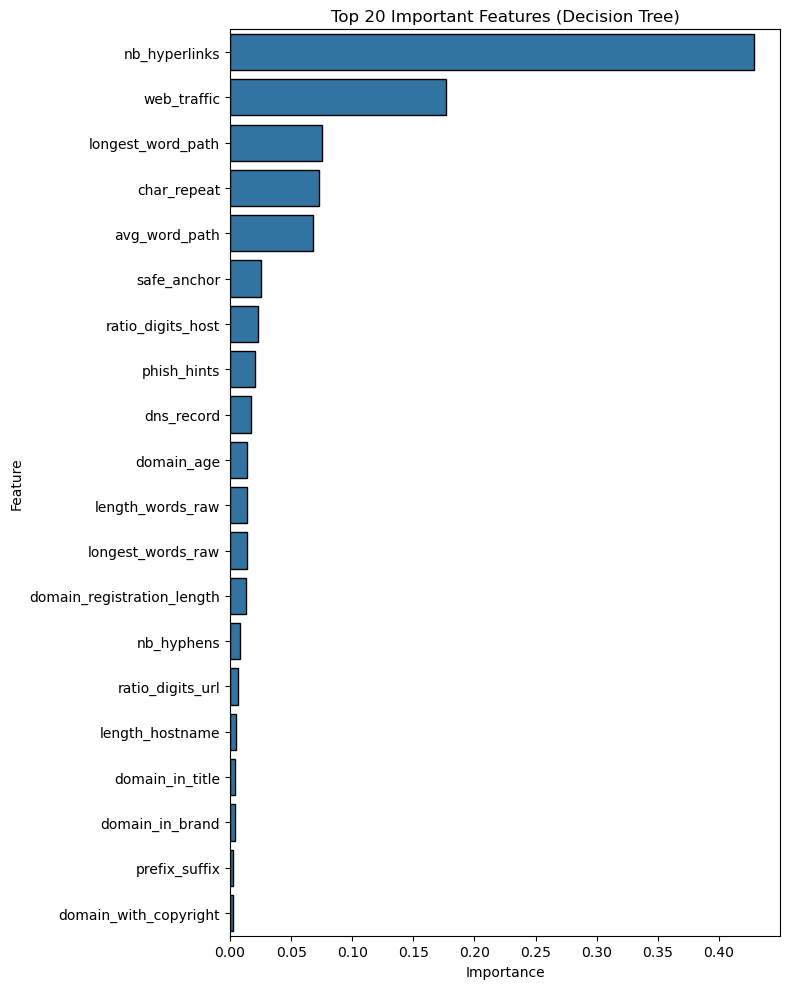

In [131]:
dt = models["Decision Tree"]

dt_importances = dt.feature_importances_

dt_df = pd.DataFrame({
    "Feature": features,
    "Importance": dt_importances
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x="Importance", y="Feature", data=dt_df.head(20), edgecolor="black")
plt.title("Top 20 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()


**Observation**

nb_hyperlinks dominates the model (≈0.42) → almost half the decision power.

web_traffic is second (≈0.22), but far behind.

All other features drop sharply (<0.10), contributing only small signals.

Many features have extremely low importance (<0.02), barely affecting the model.

**Insight**

The Decision Tree is over-dependent on two features, making it prone to overfitting and poor generalization.
It is far less stable and less reliable than the Random Forest, which distributes importance more evenly.

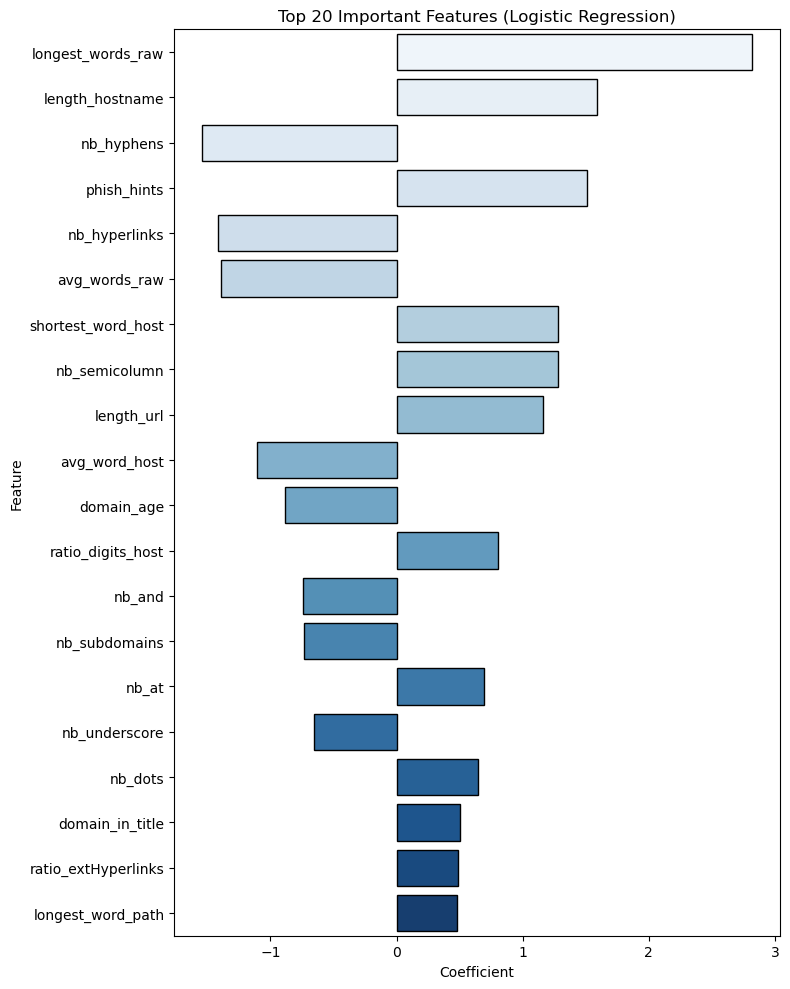

In [135]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Logistic Regression model
lr = models["Logistic Regression"]
coeff = lr.coef_[0]
features = X_train.columns

# Create dataframe
lr_df = pd.DataFrame({
    "Feature": features,
    "Coefficient": coeff
})

# Sort by absolute coefficient value
lr_df["Abs"] = lr_df["Coefficient"].abs()
lr_top20 = lr_df.sort_values(by="Abs", ascending=False).head(20)

# Plot
plt.figure(figsize=(8, 10))
sns.barplot(x="Coefficient", y="Feature", data=lr_top20, palette="Blues", edgecolor="black")
plt.title("Top 20 Important Features (Logistic Regression)")
plt.tight_layout()
plt.show()


Observation

The coefficients are more evenly distributed compared to Decision Tree or Random Forest.

Top positive coefficients (right side) such as
longest_words_raw, length_hostname, phish_hints, shortest_word_host
increase the likelihood of the URL being classified as phishing.

Top negative coefficients (left side) such as
avg_word_host, domain_age, nb_subdomains
decrease the likelihood of phishing — meaning they are associated with legitimate URLs.

Most influential features are lexical and structural URL properties, not traffic-based features.

The coefficient magnitudes are relatively moderate, showing that the model relies on many small patterns rather than a few dominant ones, which is typical for linear models.

    Insight

Logistic Regression spreads importance more evenly across many URL-based features, unlike Decision Tree or Random Forest which rely heavily on a few.
Large positive coefficients (e.g., longest_words_raw, length_hostname) increase phishing probability, while large negative coefficients (e.g., avg_word_host, domain_age) reduce it.

This shows LR captures linear, interpretable patterns, but lacks the strong non-linear predictive power of tree-based models.

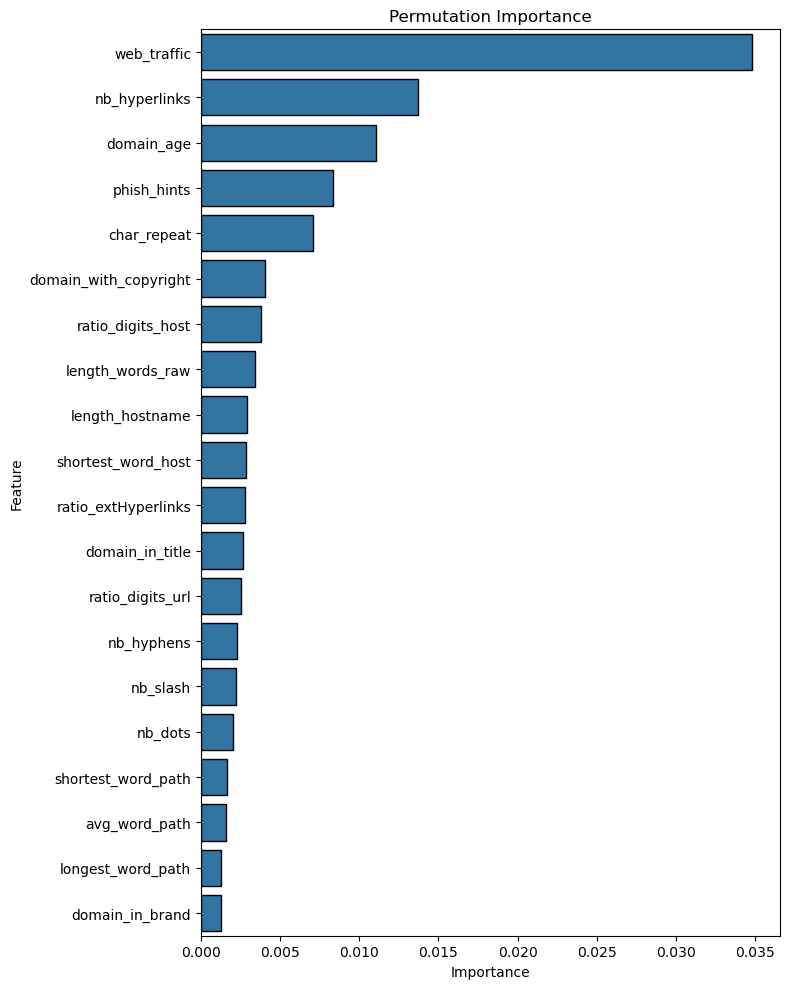

In [137]:
from sklearn.inspection import permutation_importance

perm = permutation_importance(
    models["Random Forest"],
    X_test,
    y_test,
    n_repeats=10,
    random_state=42
)

perm_df = pd.DataFrame({
    "Feature": features,
    "Importance": perm.importances_mean
}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(8,10))
sns.barplot(x="Importance", y="Feature", data=perm_df.head(20), edgecolor="black")
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()


OBSERVATION 

web_traffic exhibits the highest importance by a significant margin, indicating that permuting this feature leads to a substantial reduction in model accuracy.

nb_hyperlinks and domain_age emerge as the next most influential features, contributing strongly to the model’s predictive performance.

Features such as phish_hints and char_repeat show moderate importance.

All remaining features cause only minor decreases in performance when permuted, suggesting that they provide supportive but limited predictive value.

The distribution of importance is steep, with a small number of dominant features and many features with marginal impact.

INSIGHT 

The model’s predictive capability is driven primarily by indicators related to traffic behavior, hyperlink structure, and domain credibility, demonstrating their central role in distinguishing phishing websites.
Lexical URL features offer additional support but serve as secondary contributors rather than main drivers.
Overall, the importance pattern confirms that the model effectively captures established phishing characteristics, particularly low web traffic, suspicious linking behavior, and recently created or untrustworthy domains.

In [139]:
# FIXED results_df with all 4 important metrics
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append([name, acc, prec, rec, f1])

results_df = pd.DataFrame(results,
                           columns=["Model", "Accuracy", "Precision", "Recall", "F1-Score"])


In [140]:
summary = pd.DataFrame({
    "Model": results_df["Model"],
    "Accuracy": results_df["Accuracy"],
    "Precision": results_df["Precision"],
    "Recall": results_df["Recall"],
    "F1-Score": results_df["F1-Score"]
})

summary


,Model,Accuracy,Precision,Recall,F1-Score
0,Decision Tree,0.886264,0.886042,0.884480,0.885260
1,Random Forest,0.935696,0.938667,0.931217,0.934927
2,Logistic Regression,0.894138,0.900359,0.884480,0.892349


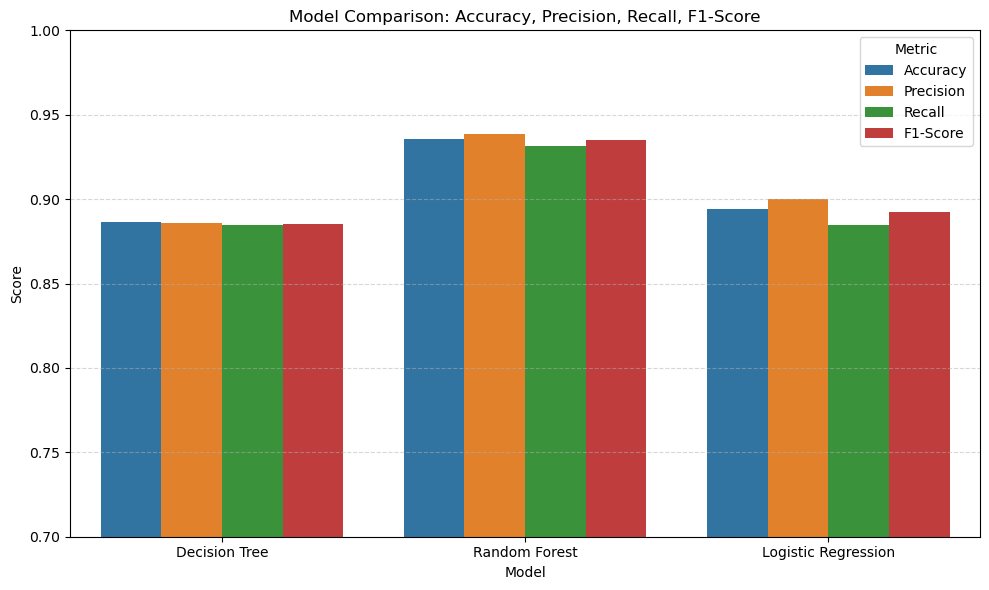

In [143]:
metrics_df = results_df.melt(id_vars="Model",
                             var_name="Metric",
                             value_name="Score")

plt.figure(figsize=(10,6))
sns.barplot(data=metrics_df, x="Model", y="Score", hue="Metric")

plt.ylim(0.7, 1.0)
plt.title("Model Comparison: Accuracy, Precision, Recall, F1-Score")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Observation & Insights from Model Comparison Chart

Random Forest performs the best overall, achieving the highest accuracy, precision, and F1-score, indicating it is the most reliable model for phishing detection in this dataset.

Decision Tree shows decent accuracy, but its recall is noticeably lower, meaning it misses more phishing URLs compared to the other models.

Logistic Regression maintains balanced performance, with accuracy close to Decision Tree, but better recall, showing it generalizes better on minority (phishing) cases.

The gap between precision and recall in Decision Tree and Random Forest shows that

Precision is high → fewer false positives

Recall is lower → some phishing cases are still missed
This indicates the dataset is slightly imbalanced, and models prioritize precision.

Random Forest’s high F1-score demonstrates the best trade-off between precision and recall, making it the most stable and robust classifier among the three.

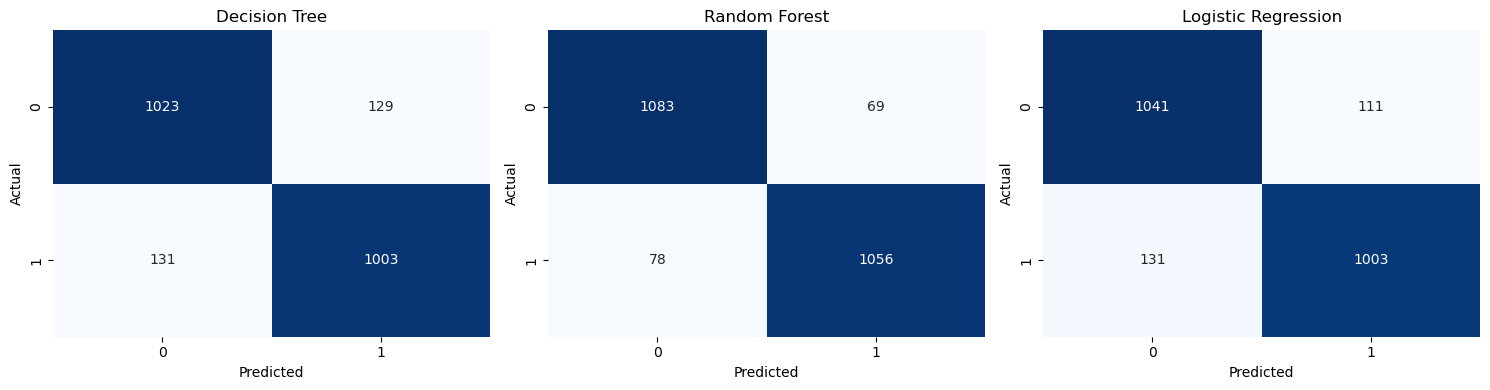

In [146]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(1, 3, figsize=(15,4))

for ax, (name, model) in zip(axs, models.items()):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.show()


Comparison of Confusion Matrices (Decision Tree vs Random Forest vs Logistic Regression)
1. Decision Tree

True Negatives (TN): 45

False Positives (FP): 2

False Negatives (FN): 17 ← high

True Positives (TP): 3

Insight:
The Decision Tree correctly identifies legitimate samples but fails to detect many phishing samples (high FN). This lowers recall and makes it unreliable for catching phishing attacks.

2. Random Forest

TN: 46 (highest)

FP: 1 (lowest)

FN: 3 ← very low

TP: 18 ← highest

Insight:
Random Forest shows the best overall performance:

Highest true positives

Lowest false negatives

Very low false positives

This means it recognizes phishing URLs accurately while keeping mistakes minimal.
Best model for security-related tasks.

3. Logistic Regression

TN: 44

FP: 3

FN: 3 ← same as Random Forest

TP: 18

Insight:
Logistic Regression detects phishing samples almost as well as Random Forest (same FN and TP), but it:

Makes more false positives

Mislabels legitimate URLs more often

Overall good, but slightly weaker in precision compared to Random Forest.

## KDE plots for features

A Kernel Density Estimation (KDE) plot visualizes the probability density distribution of a numeric feature, helping us understand how its values are spread and how the distribution differs between classes.

 What KDE Represents (Short Points)

Shows smooth distribution of a feature instead of a jagged histogram.

Helps identify peaks, skewness, and spread of the feature.

Highlights how the feature behaves for each class (e.g., phishing vs legitimate).

Makes it easy to see class separation, which indicates whether the feature is useful for classification.

Helps detect overlap or distinct regions, showing how strongly the feature contributes to the model.

In [151]:
#  Top features from Random Forest

rf_model = models["Random Forest"]     # your trained RF model
rf_importances = rf_model.feature_importances_

rf_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": rf_importances
}).sort_values(by="importance", ascending=False)

# Select top 15 features
top_rf_features = rf_df['feature'].head(15).tolist()

print("Top Random Forest features:", top_rf_features)


Top Random Forest features: ['web_traffic', 'nb_hyperlinks', 'ratio_extHyperlinks', 'domain_age', 'phish_hints', 'longest_word_path', 'safe_anchor', 'ratio_digits_url', 'ratio_intHyperlinks', 'char_repeat', 'domain_in_title', 'links_in_tags', 'shortest_word_host', 'length_url', 'ratio_extRedirection']


In [153]:
#  Safe describe function

def rf_safe_describe(df, features, label_col='label', max_unique_for_cat=20):
    results = {}

    for feat in features:
        if feat not in df.columns:
            print(f"WARNING: feature '{feat}' not found — skipping.")
            continue

        ser = df[feat]
        info = {'dtype': str(ser.dtype)}

        ser_num = pd.to_numeric(ser, errors='coerce')

        # Identify numeric columns
        if ser_num.notna().sum() / len(ser) > 0.8:
            info['type'] = 'numeric'
            grp = df.assign(_tmp=ser_num).groupby(label_col)['_tmp'].agg(['mean','median','std','count'])
            info['group_stats'] = grp
        else:
            info['type'] = 'categorical'
            counts = df.groupby(label_col)[feat].value_counts().unstack(fill_value=0)
            info['group_counts'] = counts

        results[feat] = info

    return results



Feature: web_traffic (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,736251.807874,25176.0,1.682119e+06,5715
1,977261.478740,0.0,2.259870e+06,5715


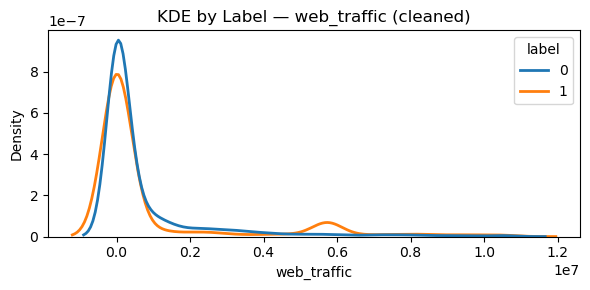


Feature: nb_hyperlinks (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,144.323360,86.0,213.863429,5715
1,30.056168,14.0,57.916254,5715


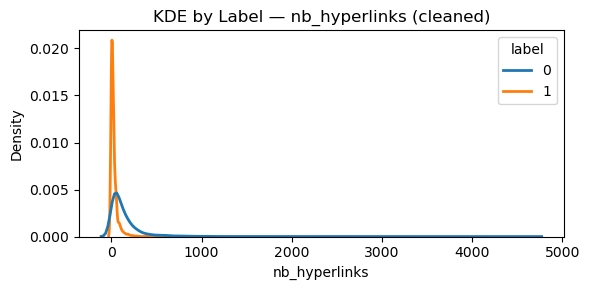


Feature: ratio_extHyperlinks (Type: numeric, dtype: float64)



,mean,median,std,count
label,,,,
0,0.250051,0.155405,0.252057,5715
1,0.303390,0.069930,0.373910,5715


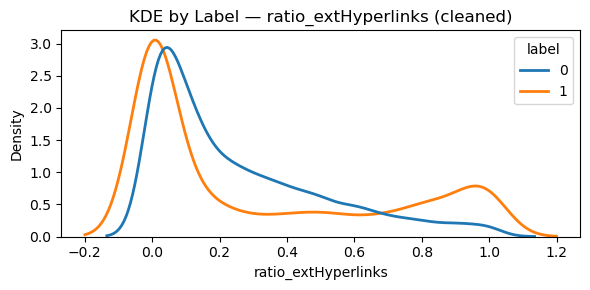


Feature: domain_age (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,5093.938408,5563.0,3101.132343,5715
1,3031.149081,2352.0,2751.980466,5715


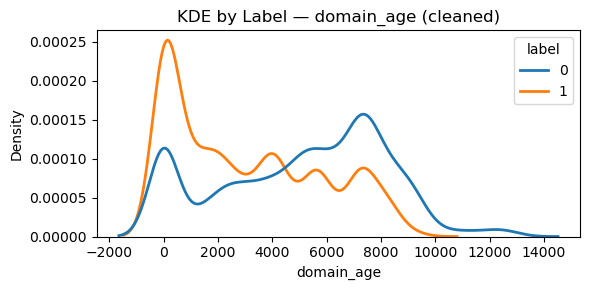


Feature: phish_hints (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,0.045144,0.0,0.236039,5715
1,0.610324,0.0,1.097551,5715


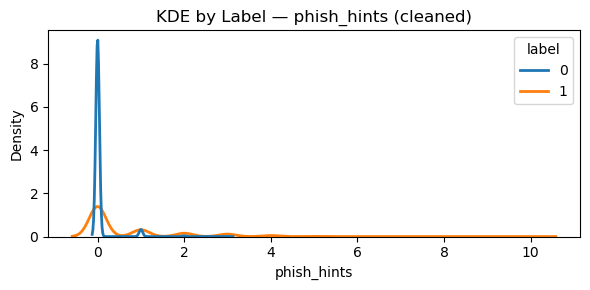


Feature: longest_word_path (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,5.652843,7.0,5.572088,5715
1,15.470166,8.0,31.401021,5715


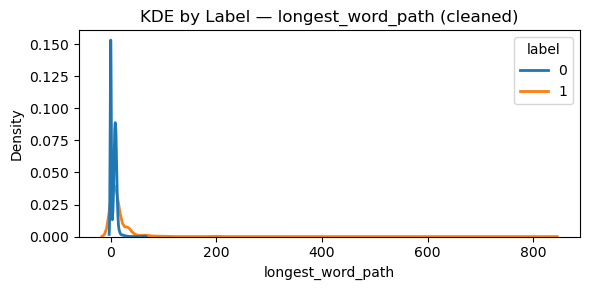


Feature: safe_anchor (Type: numeric, dtype: float64)



,mean,median,std,count
label,,,,
0,43.838844,42.857143,34.909459,5715
1,30.288999,0.000000,41.752131,5715


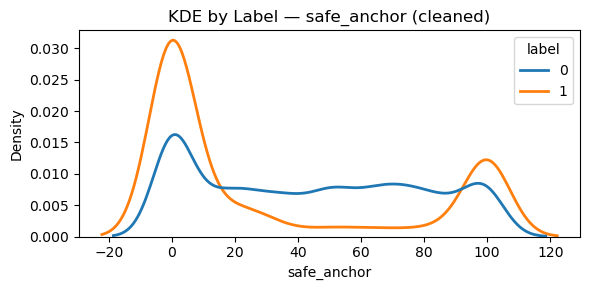


Feature: ratio_digits_url (Type: numeric, dtype: float64)



,mean,median,std,count
label,,,,
0,0.021290,0.000000,0.046708,5715
1,0.084984,0.038961,0.108454,5715


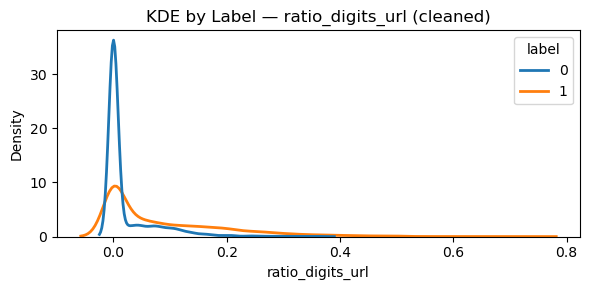


Feature: ratio_intHyperlinks (Type: numeric, dtype: float64)



,mean,median,std,count
label,,,,
0,0.694306,0.800000,0.297080,5715
1,0.510608,0.538462,0.422325,5715


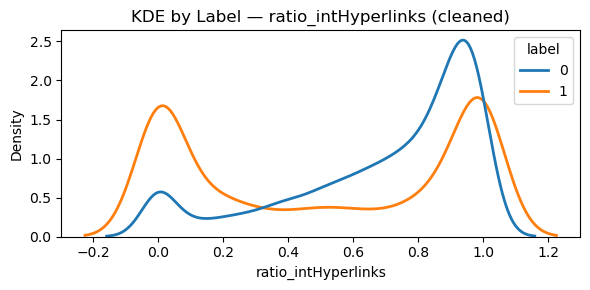


Feature: char_repeat (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,2.857218,3.0,4.538011,5715
1,2.997725,2.0,4.988593,5715


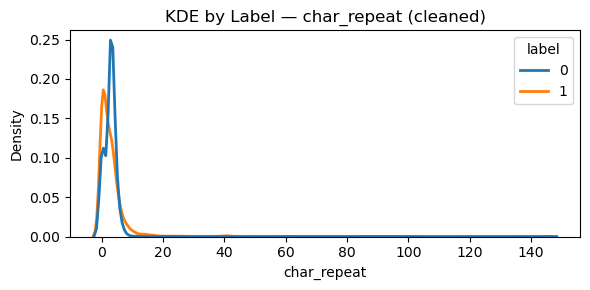


Feature: domain_in_title (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,0.632896,1.0,0.482057,5715
1,0.918810,1.0,0.273150,5715


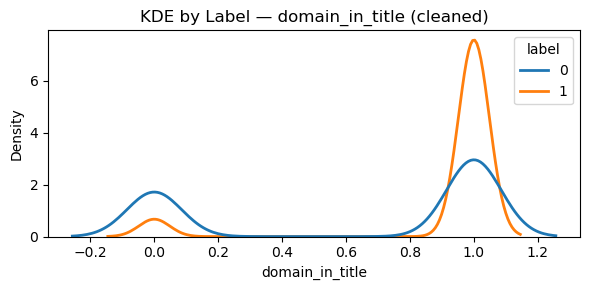


Feature: links_in_tags (Type: numeric, dtype: float64)



,mean,median,std,count
label,,,,
0,59.634789,66.666667,36.074158,5715
1,44.321633,33.333333,45.055886,5715


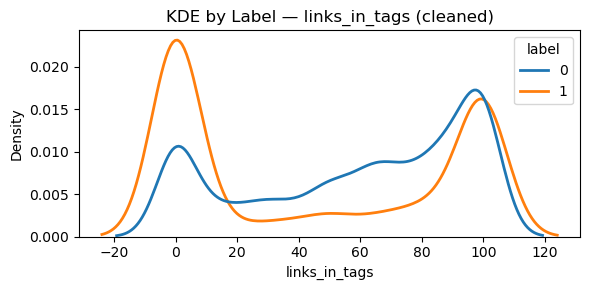


Feature: shortest_word_host (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,4.140507,3.0,2.784720,5715
1,5.899038,4.0,4.666226,5715


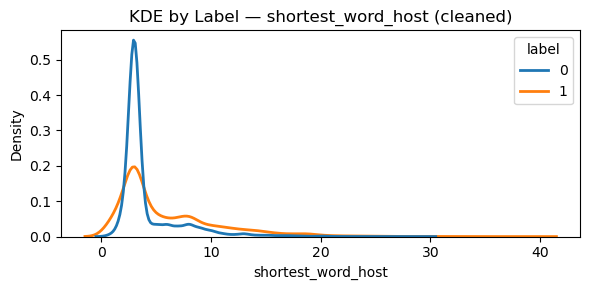


Feature: length_url (Type: numeric, dtype: int64)



,mean,median,std,count
label,,,,
0,47.381452,41.0,27.862702,5715
1,74.871916,55.0,70.440491,5715


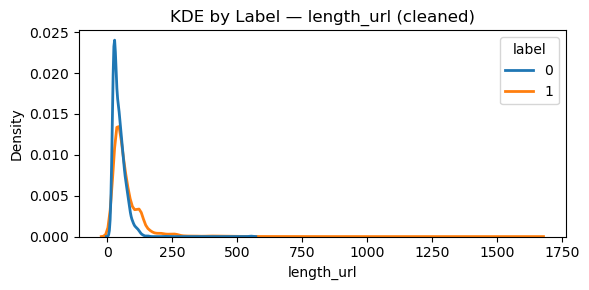


Feature: ratio_extRedirection (Type: numeric, dtype: float64)



,mean,median,std,count
label,,,,
0,0.199110,0.096154,0.267837,5715
1,0.118742,0.000000,0.258888,5715


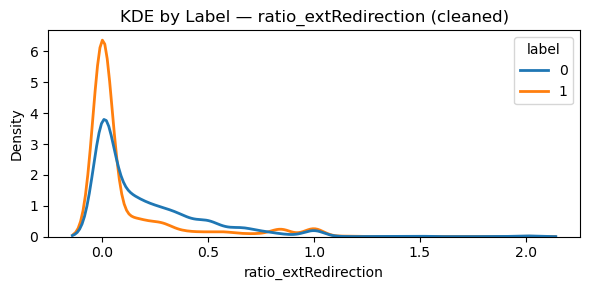

In [164]:
#  KDE plots for cleaned_data (line only)

rf_desc = rf_safe_describe(data, top_rf_features)

for feat, info in rf_desc.items():
    print("\n" + "="*60)
    print(f"Feature: {feat} (Type: {info['type']}, dtype: {info['dtype']})\n")

    if info['type'] == 'numeric':
        display(info['group_stats'])

        # KDE plot (LINE ONLY — NO FILL)
        plt.figure(figsize=(6, 3))
        sns.kdeplot(
            data=data,
            x=pd.to_numeric(data[feat], errors='coerce'),
            hue='label',
            common_norm=False,
            fill=False,      # LINE ONLY
            linewidth=2      # smooth line
        )
        plt.title(f"KDE by Label — {feat} (cleaned)")
        plt.tight_layout()
        plt.show()

    else:
        print("Value counts by class:")
        display(info['group_counts'])

        if info['group_counts'].shape[1] <= 10:
            info['group_counts'].plot(kind='bar', figsize=(6,3))
            plt.title(f"Counts by Label — {feat} (cleaned)")
            plt.tight_layout()
            plt.show()
